# Tutorial: Searching a TraP dataset for transient and variable sources
## Author: Antonia Rowlinson

This Jupyter Notebook is a demo for demonstrating the current best practice for searching for transients and variable sources in the output from the LOFAR Transients Pipeline, TraP (Swinbank et al. 2015). TraP is a publicly available pipeline with the following resources:
- [Code](https://github.com/transientskp/tkp)
- [Documentation](https://docs.transientskp.org)
- [Publication](https://ui.adsabs.harvard.edu/abs/2015A%26C....11...25S/abstract)

Example recent transient surveys using TraP outputs:
- Identifying radio transient and variable sources with statistical methods [Valdata et al. (in prep)]()
- A new method for short-duration transient detection in radio images: searching for transient sources in MeerKAT data of NGC 5068 [Fijma et al. 2024](https://ui.adsabs.harvard.edu/abs/2024MNRAS.528.6985F/abstract)
- Commensal transient searches in eight short gamma-ray burst fields [Chastain et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.1888C/abstract)
- LOFAR observations of gravitational wave merger events: O3 results and O4 strategy [Gourdji et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.4748G/abstract)
- Search and identification of transient and variable radio sources using MeerKAT observations: a case study on the MAXI J1820+070 field [Rowlinson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.517.2894R/abstract)
- 21 new long-term variables in the GX 339-4 field: two years of MeerKAT monitoring [Driessen et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.5037D/abstract)
- Identifying transient and variable sources in radio images [Rowlinson et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26C....27..111R/abstract)


The methods presented in this Jupyter Notebook are the culmination of years working with the TraP outputs. 

Please cite the appropriate papers from above when using these tools.

**CAVEATS:** 
- These methods may not catch everything interesting/unusual in the TraP databases! We are still refining search techniques to find out more.
- Get to know your data to confirm these 'standard' settings work for you! I recommend studying a small percentage of large datasets to get a feel for what type of filtering and processing strategy works best for you.
- This Jupyter Notebook will be slow for very large datasets. Split it into smaller processes or standalone scripts.

### Quality Control: Pre-TraP Assessment

Quality control of your data is essential for ensuring that you minimise the number of false positive detections. We have found that the simplest and most optimal method for datasets checked to date is implementing an rms noise clip on your images. This clipping can be conducted in TraP, but you need to determine what the optimal settings are for your data. n.b. there is an automated version in TraP, but it is currently very slow and I recommend you do not use it.

The code below will load all images in the path and calculate the rms noise in the inner part of your image. This is the identical method to that used in TraP to determine the rms noise in the images. The documentation for this part of TraP is [here](https://tkp.readthedocs.io/en/release4.0/userref/structure/stages/quality.html). The TraP also conducts a check on the restoring beam shape and for nearby bright sources.

This code is based upon the PreTraPimageQC code in [TraP_tools](https://github.com/transientskp/TraP_tools/tree/master).

**CAVEATS** 
- This part assumes you only have 1 observing frequency. See the full code for how to handle multiple frequency datasets.
- The version below fits the rms noise in linear space whereas in the full code we used log space. Further investigation required to determine if linear space is sufficient.
- For very large datasets, this gets very slow. I recommend using a representative subset, e.g. 10%, to characterise what a good image should look like and then apply the thresholds to your full dataset in TraP. Conducting a random sample of your images is now implemented in this code.

In [7]:
import sys
import os
import astropy.io.fits as pyfits
import numpy as np
import glob
import pandas as pd
from matplotlib import pyplot as plt 
import random
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy.io import fits
from astropy.stats import sigma_clip


In [8]:
import getRMS  
# This is a script that is in the github repository associated with this code. 
# It will calculate a sigma clipped rms in the inner region of the images being processed.
# The clipping factor and relative size of the image to be considered can be input as parameters.

In [ ]:
randomPercentage = 1 # 0.005
# This is the percentage of the data you want to use for the quality control steps

In [ ]:
sigmaClip = 3 # This is the sigma clip used to remove sources from the rms calculation. 
# Usually 3 is used in TraP (see rms_est_sigma in the job_config)

In [ ]:
f = 8 # This is the fraction of the image that will be used for the rms calculation.
# Usually 8 is used in TraP.

In [ ]:
sigmaRej = 3 # This is the rejection sigma for bad images.
# If the image is deviant from the mean by more than this value (positive or negative) the image is rejected.

In [ ]:
path_to_images = '/scratch/antoniar/ELAIS_deep_images/'

Read all the images and measure the rms noise in the central region. Store as a Pandas dataframe.

In [ ]:
imageList = glob.glob(path_to_images+'*.fits')
numImages = len(imageList)
randomImages = random.sample(imageList,int(randomPercentage*numImages))
print(len(randomImages))
numImages

In [ ]:
if os.path.exists('image_rms.csv'):
    imageData = pd.read_csv('image_rms.csv')
else:
    imageData=[]
    for filename in randomImages:
        data = getRMS.read_data(pyfits.open(filename)[0],filename, plane=None)
        imageData.append([filename, getRMS.rms_with_clipped_subregion(data, sigmaClip, f)*1000.])

    imageData = pd.DataFrame(imageData, columns=['filename','rms'])
    imageData.to_csv('image_rms.csv')
imageData

Fit a histogram to the rms noise values. n.b. sometimes you have to tweak the number of bins (here and in the boxes 19 & 20) to get the Gaussian fitting working sufficiently well for your data.

In [ ]:
plt.hist(imageData.rms,bins=50,histtype='stepfilled')

plt.xlabel('rms noise (mJy/beam)')
plt.ylabel('Number of images')

plt.show()

Drop images that have NaN as their rms value and those with extreme rms values. And remove from the Random Sample for later processing steps.

In [ ]:
imageData = imageData.dropna()
newlist = imageData.filename.tolist()
randomImages=[x for x in randomImages if x in newlist]

mean=np.mean(imageData.rms)
median=np.median(imageData.rms)
stdev = np.std(imageData.rms)
print(mean,median,stdev)

rmsVals = imageData.rms
rmsVals = sigma_clip(rmsVals, sigma=6, maxiters=5, cenfunc='median', masked=False) # clip out the sources
        
imageData = imageData[imageData.rms < np.max(rmsVals)]

plt.hist(imageData.rms,bins=50,histtype='stepfilled')

plt.xlabel('rms noise (mJy/beam)')
plt.ylabel('Number of images')

plt.show()

In [ ]:
# functions to fit a Gaussian distribution to data

def res(p, y, x):
# calculate residuals between data and Gaussian model
  m1, sd1, a = p
  y_fit = a*norm2(x, m1, sd1)
  err = y - y_fit
  return err

def guess_p(x):
# estimate the mean and rms as initial inputs to the Gaussian fitting
    median = np.median(x)
    temp=[n*n-(median*median) for n in x]
    rms = math.sqrt((abs(sum(temp))/len(x)))
    return [median, rms, math.sqrt(len(x))]

def norm2(x, mean, sd):
# creates a normal distribution in a simple array for plotting
    normdist = []
    for i in range(len(x)):
        normdist += [1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x[i] - mean)**2/(2*sd**2))]
    return np.array(normdist)

In [ ]:
from scipy.optimize import leastsq
import math

# Obtain the data in a binned histogram for fitting
hist_rms=np.histogram(imageData.rms,bins=500)
range_x=[hist_rms[1][n]+(hist_rms[1][n+1]-hist_rms[1][n])/2. for n in range(len(hist_rms[1])-1)]

# Guess the mean and standard deviation based upon the median value
p = guess_p(imageData.rms)

# Calculate the best fitting Gaussian distribution
plsq = leastsq(res, p, args = (hist_rms[0], range_x)) # fit Gaussian to data
fit2 = plsq[0][2]*norm2(range_x, plsq[0][0], plsq[0][1]) # create Gaussian distribution for plotting on graph

In [ ]:
# Create a plot of the results

plt.plot(range_x,fit2, 'r-', linewidth=3)
plt.hist(imageData.rms,bins=500,histtype='stepfilled')

sigcut=plsq[0][0]+plsq[0][1]*sigmaRej # max threshold defined as (mean + RMS * sigma)
sigcut2=plsq[0][0]-plsq[0][1]*sigmaRej # min threshold defined as (mean - RMS * sigma)
plt.axvline(x=sigcut, linewidth=2, color='k',linestyle='--')
plt.axvline(x=sigcut2, linewidth=2, color='k', linestyle='--')

plt.xlabel('rms noise (mJy/beam)')
plt.ylabel('Number of images')

plt.savefig('rms_plot.png')
plt.show()

In [ ]:
# Thresholds for TraP job parameters file (job_params.cfg):
rms_est_max=sigcut/1e3
rms_est_min=sigcut2/1e3
print('rms_est_max = '+ str(rms_est_max))
print('rms_est_min = '+ str(rms_est_min))

Remove the rejected images from the random sample of images for the next tests.

In [ ]:
imageData = imageData[(imageData.rms < rms_est_max*1e3) & (imageData.rms > rms_est_min*1e3)]
newlist = imageData.filename.tolist()
randomImages=[x for x in randomImages if x in newlist]
print(imageData)

### Choosing an appropriate systematic position offset

The position uncertainties output by the transients pipeline are only measurement errors and do not account for systematic position uncertainties caused by e.g. the ionosphere.

Setting this systematic position offset to be too high will lead to bad source associations and not including it means that bright sources may not be correctly associated.

Here we use a random sample of images in the dataset to quantify the typical position offset in snapshot images versus the source position in a deep image of the field. We use a simple source association procedure from astropy.


In [ ]:
deepImage = '/scratch/antoniar/ELAIS_deep_images/L229064_image_full_ampphase_di_m.NS.int.restored_scaled.fits'
detectThresh = 8.
detectThreshDeep = 20.
radius = 6000 #900 # pixels
radiusDeep = 6000 #3600
grid = 50 # pixels
deblend = 0 # 0 = turned off
forceBeam = True
maxSep = 20  # arcsec
minSNR = 20 # use a large value to ensure that you are only using the brightest sources to estimate the uncertainty

Run the source finder, PySE, on all the images in the random sample of images to measure the positions of the sources and their uncertainties.

In [ ]:
for image in randomImages:
    img = image.split('.fits')[0]+'.csv'
    img = img.split('/')[-1]
    if os.path.isfile(img):
        print(img)
    else:
        if forceBeam:
            os.system('pyse.py --detection '+str(detectThresh)+' --deblend-thresholds '+str(deblend)
                      +' --grid '+str(grid)+' --radius '+ str(radius)+' --force-beam --csv '+image)
        else:
            os.system('pyse.py --detection '+str(detectThresh)+' --deblend-thresholds --csv '+str(deblend)
                      +' --grid '+str(grid)+' --radius '+ str(radius)+image)

Run PySE on the deep image to get the main source catalogue. Use 20 sigma detection threshold so only brighter sources. Otherwise the same PySE settings.

In [ ]:
img = deepImage.rstrip('.fits')+'.csv'
img = img.split('/')[-1]
if os.path.isfile(img):
    runcat =pd.read_csv(img, delimiter=', ', engine='python')
else:       
    if forceBeam:
        os.system('pyse.py --detection '+str(detectThreshDeep)+' --deblend-thresholds '+str(deblend)
                    +' --grid '+str(grid)+' --radius '+ str(radiusDeep)+' --force-beam --csv '+deepImage)
    else:
        os.system('pyse.py --detection '+str(detectThreshDeep)+' --deblend-thresholds --csv '+str(deblend)
                    +' --grid '+str(grid)+' --radius '+ str(radiusDeep)+deepImage)
    runcat =pd.read_csv(img, delimiter=', ', engine='python')
#print(runcat.columns.tolist())
runcat['SkyCoords'] = runcat.apply(lambda row: coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), axis=1)
#print(runcat)
rct = coord.SkyCoord(runcat.ra, runcat.dec, unit=(u.deg, u.deg), frame='fk5')

Loop through all the images to determine the offset from the deep image position. Use astropy source association

In [ ]:
if os.path.exists('seps.csv'):
    AllSeps = pd.read_csv('seps.csv')
else:
    AllSeps = pd.DataFrame(columns = ['img','ra_err','dec_err','sep','snr'])
    for image in randomImages:
        img = image.split('.fits')[0]+'.csv'
        img = img.split('/')[-1]
        sources = pd.read_csv(img, delimiter=', ', engine='python')
        sources['SkyCoords'] = sources.apply(lambda row: coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), axis=1)
        srcs = coord.SkyCoord(sources.ra, sources.dec, unit=(u.deg, u.deg), frame='fk5')
        idx, d2d, d3d = srcs.match_to_catalog_sky(rct)
        seps = np.array(d2d.arcsecond)     
        sources['sep']=seps
        sources['img']=img
        sources = sources.filter(['img','ra_err','dec_err','sep','snr'])
        AllSeps = pd.concat([AllSeps, sources])
    
    AllSeps.to_csv('seps.csv')

Conduct selections on the data to reject bad associations (using maxSep) and to focus on only the high SNR sources

In [ ]:
AllSeps = AllSeps[AllSeps.sep < maxSep]
AllSeps = AllSeps[AllSeps.snr > minSNR]

The offsets being measured should be a combination of the fitting error and the systematic error. These are normally added in quadrature. i.e. offset = sqrt ( ra_error^2 + dec_error^2 + systematic^2) --> offset^2 / (ra_error^2 + dec_error^2 ) = systematic^2
We use the median values so as not to be biased towards larger offsets.


In [ ]:
systematic = np.median(AllSeps.sep)**2. / (np.median(3600*AllSeps.ra_err)**2. + np.median(3600*AllSeps.dec_err)**2.)
print(systematic**0.5)

### Setting a source detection threshold

Choosing an appropriate source detection threshold is very important for transient searches - too low and you will be inundated with false positives and too high will miss key transients.

Here we implement the method outlined in Fijma et al. (2023) and de Ruiter et al. (2024). We assume the images have Gaussian noise (not true for radio images but good enough assumption for this method). Then we choose a detection threshold that would lead to e.g. 1 pixel above the detection threshold in the survey - this is then scaled to the size of the restoring beam as this is the expected size of a source. For large surveys, we use a subset of the data to determine this threshold and extrapolate to the full survey. We also choose a threshold that would lead to 1 detection per XX hours or observations or images. For instance 1 pixel in 50x 8 hour observations.

In [ ]:
sig_clip=6. # median sigma clipping value - used to clip the sources out of the images
srch_radius=radius #Search radius in pixels - same as used in TraP
img_cntr= [7072,7072] #[1100,1100] # image centre in pixels
img_percent_per_fp = 1. # how much data that we want to have max 1 false positive in

BMAJ=0.001666666666666667 # in degrees
CDELT1 = 0.00041666666666667 # the size in degrees of 1 pixel 
radBeam = BMAJ/CDELT1 # radius in pixels
pixels_in_beam = int(np.pi * radBeam**2.)
fp_percentage = 0.01 # probability of getting a false positive is <1%

In [ ]:
from regions import CirclePixelRegion, PixCoord

# Create a mask to select only the pixels that are searched by the TraP
region_sky = CirclePixelRegion(center=PixCoord(img_cntr[0],img_cntr[1]), radius=srch_radius)
mask = region_sky.to_mask(mode='exact')


Grab the pixel data from all the images in the random sample of images used earlier. This is the value of every pixel within the TraP search radius. Remember to delete the pixels_data.csv file if you are using a new set of random images.

New Method - measure best and worst to get bins for the histogram. Then use the random sample to characterise as before, but this time the data are immediately binned to make the code more efficient in memory usag

In [ ]:
def readpixels(filename,sig_clip):
    hdu = fits.open(filename)
    data = mask.cutout(hdu[0].data[0][0])
    newpix=data.flatten()
    newpix = newpix[~np.isnan(newpix)]
    newpix = sigma_clip(newpix, sigma=sig_clip, maxiters=2, cenfunc='mean', masked=False) # clip out the sources
    return newpix

def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))


In [ ]:
if os.path.exists("pixels_data.csv"):
    print('reading pixels data file and bins data file')
    pixels = np.fromfile("pixels_data.csv",dtype=float,sep="\n")
    final_bins = np.fromfile("bins_data.csv",dtype=float,sep="\n")
    print('data read')
else:
    # Collating all the pixel values in the images
    print('Getting pixel data')
    
    min_rms = np.min(imageData.rms)
    max_rms = np.max(imageData.rms)
    min_img = imageData.loc[imageData['rms'] == min_rms]
    max_img = imageData.loc[imageData['rms'] == max_rms]

    newpix = readpixels(min_img.filename.values[0],sig_clip)
    min_bin=np.min(list(newpix))
    
    newpix = readpixels(max_img.filename.values[0],sig_clip)
    max_bin=np.max(list(newpix))
    
    nbins=250
    n, final_bins, patches = plt.hist(newpix, nbins, range=(min_bin,max_bin), color='b',histtype='stepfilled')   
    
    pixels = np.zeros(len(n))
    for img in randomImages:
        newpix = readpixels(img,sig_clip)
        n, bins, patches = plt.hist(newpix, final_bins, color='b',histtype='stepfilled')
        pixels = pixels + n
    
    print('writing data to pixels_data.csv and bins_data.csv')
    np.savetxt("pixels_data.csv", pixels, delimiter=",")
    np.savetxt("bins_data.csv", final_bins, delimiter=",")
    print('data written')


In [ ]:
from scipy.optimize import curve_fit

bins = (final_bins[:-1] + np.diff(final_bins) / 2)
x_values_to_fit = np.linspace(np.min(final_bins),np.max(final_bins),100)
params, cov = curve_fit(gaussian, bins,pixels, p0=(np.max(pixels),0,1e-5))

In [ ]:
print('Number of pixels in dataset = '+str(sum(pixels)))
print('Number of beams in dataset = '+str(float(sum(pixels))/float(pixels_in_beam)))

In [ ]:
from scipy.stats import norm
numPixSample=sum(pixels)
numImgsSample = len(randomImages)
#numImages # total number of images in the survey

numBeamsSample = float(numPixSample)/float(pixels_in_beam) # number of unique beams sampled in the random image dataset
numBeams = numBeamsSample * (float(numImages) / float(numImgsSample)) # total number of unique beams sampled in the full dataset
numBeamsThresh = numBeamsSample * (float(numImages)*img_percent_per_fp / float(numImgsSample)) # total number of unique beams per sample that we want 1 false positive in

percentage = 1. - fp_percentage/numBeamsThresh
limit=norm.ppf(percentage, loc=params[1], scale=params[2])
siglimit=(limit-params[1])/params[2]
print('Sigma limit for transients:'+str(siglimit))


In [ ]:
plt.hist(final_bins[:-1], final_bins, weights=pixels)
plt.plot(x_values_to_fit, gaussian(x_values_to_fit, *params), '-', color = 'purple', lw=1.5)

plt.axvline(params[1]+siglimit*params[2],color='k')

# plotting commands
plt.xlim(params[1]-10*params[2],params[1]+10*params[2])
plt.yscale('log')
plt.ylim(min(pixels),max(pixels)*1.2)
#plt.ylim(0,np.max(pixels)*1.01)
#plt.xlabel('Pixel value (Jy beam$^{-1}$)')
plt.ylabel('Number of pixels')

# plotting with good axes labels
locs, labels = plt.xticks()
xlabs=[x*1e3 for x in locs]
xlabs=np.around(xlabs,decimals=1)
xlabs=[str(x) for x in xlabs]
plt.xticks(locs,xlabs)
plt.xlabel('Pixel value (mJy beam$^{-1}$)')
plt.savefig('new_pixels.png')

plt.show()

### Running the TraP

The next step in the process is running the TraP on your data. You need to set up the TraP according to the instructions and initiate a job.

The images_to_process.py file will look like with the "path_to_images" used above:

The job_params.cfg file will look like this, with the rms limits from above:

**Some advice for job_params.cfg**

Generally, the default parameters generally work well but you may want to take the following into consideration.

- I recommend preventing the automatic rms thresholding by setting *rms_est_history* to a larger number than the number of images you wish to process. While the current implementation does work, it is very slow so dramatically impacts performance.

- *detection_threshold = 8* you may want to edit this such that you can control the number of false positive detections in your images. For further details, see e.g. Section 4.1 of [Fijma et al. 2024](https://ui.adsabs.harvard.edu/abs/2024MNRAS.528.6985F/abstract).

- *extraction_radius = 250* choose an appropriate source extraction radius in pixels to cover the optimal search area in your images. I recommend that you do not go too close to the image edge.
  
- *expiration = 10* This is the number of forced fits that TraP conducts after the last detection. This number is useful for controlling the number of sources that TraP is monitoring - otherwise you could reach a scenario where every pixel is being monitored in the image. It also helps speed up the TraP.

- *ns_sys_err = 10* and *ew_sys_err = 10* Replace this with the systematic position uncertainty from your dataset

When you run TraP, make a note of the dataset id for your TraP run and insert it here. Also give the name of the database you are using:

(It's in the screen output, look for this line `tkp.steps.persistence: created dataset 101 (TRAP dataset)`)

In [68]:
dataset_id = 46
database = 'antoniar'

You now need to specify your postgresql database, username, password etc. All of this information is in the file pipeline.cfg that you used to setup the TraP. Input this into the file dblogin.py, which looks like:

The database settings are then obtained by simply importing the dblogin.py file.

In [84]:
from dblogin import *

We now open a connection to the database using SQLAlchemy.

In [85]:
import tkp.db
from sqlalchemy import *

db = tkp.db.Database(engine=engine, host=host, port=port, user=user, password=password, database=database)
db.connect()
session = db.Session()

Not configuring pre-configured database


Once this is complete, you can now access the various datasets and associated tables in the following. I recommend using [SQLAlchemy](https://www.sqlalchemy.org), but it is possible to also use SQL commands. In the following, we then consider transients and variables separately.

### Variability Searches


Much of the work in this section is based upon the methods and codes presented in [Rowlinson et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26C....27..111R/abstract) and [Valdata et al. (in prep)]()

TraP measures two variability parameters (see [Swinbank et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015A%26C....11...25S/abstract)):
 - **the reduced weighted &chi;^2 (&eta;)** : This is from a fit to the light curve assuming that the flux density of your source is constant. The larger this value, the less well it fits to a horizontal line and thus the more variable the source is.
 - **the coefficient of variation (V)** : This measures the magnitude of the flux density variation in the light curve. The larger this value, the larger the variation in the flux density measurements and thus the more variable the source is.

For reference, TraP measures this value for every single time step in the light curve. Typically (and in the following code), we just use the value associated with the last data point in the light curve when assessing the variability of sources.

Much of the following code is based on the FilterVariables.py code in [TraP_tools](https://github.com/transientskp/TraP_tools/tree/master).

First, let's get the variability parameters for all the sources in the dataset. We do this by querying the Varmetric and Runningcatalog tables in the TraP database. So first, import the tools required for those tables and then obtain the data from the database.

In [86]:
from tkp.db.model import Varmetric
from tkp.db.model import Runningcatalog

VarParams = session.query(Varmetric,Runningcatalog).select_from(join(Varmetric,Runningcatalog)).filter(Runningcatalog.dataset_id == dataset_id).all()

n.b. the original code checks for duplicate sources in this table. This was because the old version of TraP sometimes misassociated sources and made a duplicate source. Further testing is ongoing to determine if this is also the case for the latest version as the code has been improved. We do not check for duplicates in this notebook.

Next, we pull out the specific columns we require and convert them into a Pandas dataframe.

In [105]:
# Set up data for plotting
plotdata = [[VarParams[i].Runningcatalog.id, VarParams[i].Varmetric.eta_int, VarParams[i].Varmetric.v_int, VarParams[i].Varmetric.lightcurve_max, VarParams[i].Varmetric.lightcurve_median, (VarParams[i].Varmetric.band.freq_central/1e6), VarParams[i].Runningcatalog.datapoints, VarParams[i].Varmetric.newsource] for i in range(len(VarParams))]
plotdata = pd.DataFrame(data=plotdata,columns=['runcat','eta','V','maxFlx','avgFlx','freq','dpts','newSrc'])
plotdata = plotdata.fillna('N')

For simplicity, we ignore all sources that are identified as new sources. These are sources that were not identified in the first image and may be transients. The candidate transients are filtered using a different strategy (see section on Transient Searches).

We also reject any remaining sources that have 0 for one of their variability parameters.

#### Getting the positions of the sources

In [106]:
plotdata = plotdata.loc[(plotdata['eta'] > 0) & (plotdata['V'] > 0) & (plotdata['newSrc']=='N')] # & (plotdata['dpts'] > 2)]# & (plotdata['newSrc']=='N')]

In [107]:
from tkp.db.model import Extractedsource
from tkp.db.model import Assocxtrsource
from tkp.db.model import Image

In [108]:
images= session.query(Image).filter(Image.dataset_id == dataset_id).all()
images = pd.DataFrame(data=[[images[x].url,images[x].taustart_ts,np.around(images[x].band.freq_central/1e9, decimals=3)] for x in range(len(images))], columns=['Image','Time','Freq'])

We now extract the position of the sources from the database.

In [109]:
runcatData = session.query(Runningcatalog).filter(Runningcatalog.dataset_id == dataset_id).all()

positions = [[runcatData[i].id,runcatData[i].wm_ra,runcatData[i].avg_ra_err,runcatData[i].wm_decl,runcatData[i].avg_decl_err] for i in range(len(runcatData))]
positions = pd.DataFrame(data=positions,columns=['runcat','ra','ra_err','dec','dec_err'])

Combine these positions with the variable candidates.

In [110]:
plotdata = pd.merge(plotdata,positions,how='inner', on='runcat')
plotdata

runcat         eta         V    maxFlx    avgFlx        freq  dpts  \
0     109046    0.895319  0.067265  0.004401  0.003868  144.432068    57   
1     109047    0.561506  0.185146  0.001558  0.001108  144.432068    21   
2     109048    2.239686  0.064869  0.007180  0.006364  144.432068    57   
3     109049  506.283180  0.071888  0.211119  0.184340  144.432068    57   
4     109050    0.369482  0.078186  0.002679  0.002149  144.432068    57   
...      ...         ...       ...       ...       ...         ...   ...   
8874  127128    0.333824  0.103950  0.001005  0.000831  144.432068    55   
8875  127234    0.998322  0.259086  0.001461  0.000915  144.432068    30   
8876  127235    1.014561  0.261098  0.001461  0.000915  144.432068    30   
8877  127346    0.329420  0.105509  0.000998  0.000825  144.432068    49   
8878  127347    0.317898  0.103840  0.000998  0.000825  144.432068    49   

     newSrc          ra    ra_err        dec   dec_err  
0         N  247.093871  0.000555  54.896163  0.000319  
1         N  247.088929  0.000590  54.879670  0.000339  
2         N  247.079771  0.000552  54.921793  0.000317  
3         N  247.034207  0.000547  54.689765  0.000316  
4         N  247.070906  0.000567  55.076113  0.000325  
...     ...         ...       ...        ...       ...  
8874      N  243.436587  0.000595  56.094853  0.000332  
8875      N  239.893532  0.000598  55.666722  0.000337  
8876      N  239.893411  0.000598  55.666665  0.000337  
8877      N  245.094161  0.000577  54.746211  0.000333  
8878      N  245.094138  0.000577  54.746161  0.000333  

[8879 rows x 12 columns]

In [111]:
minSrcFlx = np.around(min(plotdata['avgFlx']),5)
minSrcFlx

0.00014

#### Filtering out sidelobes (Probably not needed with good systematic radius)

Sometimes sidelobes can be detected in the first image as a unique runcat source. We do not want these sources to be flagged as variable so we remove them from the list of sources to be considered.

To see a full analysis of how to handle sidelobes, refer to de Ruiter et al. (2021) and de Ruiter et al. (2023).

Here we conduct a simple cut using a fixed radius and the brightest sources in the field. This reduces the sky area surveyed so will need taking into account if you calculate transient surface density limits.

CAVEAT: This is needed for arrays like LOFAR where sidelobe artefacts occur somewhat frequently. Arrays with dishes, such as MeerKAT, do not typically need this. Look at a batch of your data and see what suits it best.

In [104]:
import astropy.units as u
from astropy.coordinates import SkyCoord

FilterRadius = 4. # in arcmin (taken from table 2 in de Ruiter et al. (2023). This is probably reasonable and conservative for most LOFAR data.
BrightSrcFlx = 0.1 # Jy

# identify the brightest sources
runcat_bright = plotdata.loc[plotdata.avgFlx > BrightSrcFlx]
SrcPos = SkyCoord(ra=(plotdata.ra.values)*u.degree,dec=(plotdata.dec.values)*u.degree)
brightSrcsPos = SkyCoord(ra=(runcat_bright.ra.values)*u.degree,dec=(runcat_bright.dec.values)*u.degree)

idx1, d2d, d3d = SrcPos.match_to_catalog_sky(brightSrcsPos)
plotdata['nearestBrtSrc'] = d2d.deg
plotdata = plotdata.loc[(plotdata.nearestBrtSrc > FilterRadius/60.) | (plotdata.nearestBrtSrc == 0)]
plotdata

runcat         eta         V    maxFlx    avgFlx        freq  dpts  \
0     109046    0.895319  0.067265  0.004401  0.003868  144.432068    57   
1     109047    0.561506  0.185146  0.001558  0.001108  144.432068    21   
2     109048    2.239686  0.064869  0.007180  0.006364  144.432068    57   
3     109049  506.283180  0.071888  0.211119  0.184340  144.432068    57   
4     109050    0.369482  0.078186  0.002679  0.002149  144.432068    57   
...      ...         ...       ...       ...       ...         ...   ...   
8874  127128    0.333824  0.103950  0.001005  0.000831  144.432068    55   
8875  127234    0.998322  0.259086  0.001461  0.000915  144.432068    30   
8876  127235    1.014561  0.261098  0.001461  0.000915  144.432068    30   
8877  127346    0.329420  0.105509  0.000998  0.000825  144.432068    49   
8878  127347    0.317898  0.103840  0.000998  0.000825  144.432068    49   

     newSrc          ra    ra_err        dec   dec_err  nearestBrtSrc  
0         N  247.093871  0.000555  54.896163  0.000319       0.209245  
1         N  247.088929  0.000590  54.879670  0.000339       0.192509  
2         N  247.079771  0.000552  54.921793  0.000317       0.233509  
3         N  247.034207  0.000547  54.689765  0.000316       0.000000  
4         N  247.070906  0.000567  55.076113  0.000325       0.310674  
...     ...         ...       ...        ...       ...            ...  
8874      N  243.436587  0.000595  56.094853  0.000332       0.385467  
8875      N  239.893532  0.000598  55.666722  0.000337       0.069426  
8876      N  239.893411  0.000598  55.666665  0.000337       0.069494  
8877      N  245.094161  0.000577  54.746211  0.000333       0.161126  
8878      N  245.094138  0.000577  54.746161  0.000333       0.161132  

[8469 rows x 13 columns]

#### Extended source filter
Filter out sources which have a poor fit to a the restoring beam using the reduced chi^2 fit


In [ ]:
extendedSrcs=[]
for index, row in plotdata.iterrows():
    sourceID = row.runcat
    extractedSrcs = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    fit_values = [extractedSrcs[x].Extractedsource.reduced_chisq for x in range(len(extractedSrcs)) if extractedSrcs[x].Extractedsource.extract_type==0]
    if len(fit_values)>1:
        if max(fit_values)>500:
            extendedSrcs.append(row.runcat)
print(extendedSrcs)

Now remove these runcats from the variability dataframe.

In [54]:
plotdata = plotdata[~plotdata['runcat'].isin(extendedSrcs)]
plotdata

NameError: name 'extendedSrcs' is not defined

In [112]:
plotdata

runcat         eta         V    maxFlx    avgFlx        freq  dpts  \
0     109046    0.895319  0.067265  0.004401  0.003868  144.432068    57   
1     109047    0.561506  0.185146  0.001558  0.001108  144.432068    21   
2     109048    2.239686  0.064869  0.007180  0.006364  144.432068    57   
3     109049  506.283180  0.071888  0.211119  0.184340  144.432068    57   
4     109050    0.369482  0.078186  0.002679  0.002149  144.432068    57   
...      ...         ...       ...       ...       ...         ...   ...   
8874  127128    0.333824  0.103950  0.001005  0.000831  144.432068    55   
8875  127234    0.998322  0.259086  0.001461  0.000915  144.432068    30   
8876  127235    1.014561  0.261098  0.001461  0.000915  144.432068    30   
8877  127346    0.329420  0.105509  0.000998  0.000825  144.432068    49   
8878  127347    0.317898  0.103840  0.000998  0.000825  144.432068    49   

     newSrc          ra    ra_err        dec   dec_err  
0         N  247.093871  0.000555  54.896163  0.000319  
1         N  247.088929  0.000590  54.879670  0.000339  
2         N  247.079771  0.000552  54.921793  0.000317  
3         N  247.034207  0.000547  54.689765  0.000316  
4         N  247.070906  0.000567  55.076113  0.000325  
...     ...         ...       ...        ...       ...  
8874      N  243.436587  0.000595  56.094853  0.000332  
8875      N  239.893532  0.000598  55.666722  0.000337  
8876      N  239.893411  0.000598  55.666665  0.000337  
8877      N  245.094161  0.000577  54.746211  0.000333  
8878      N  245.094138  0.000577  54.746161  0.000333  

[8879 rows x 12 columns]

#### Use only compact sources 
The ELAIS-N1 dataset has a compact source list. We only take sources from this list so that we do not have extended sources in the variability analysis.
We do not need to use the extended source check from the above analysis.

In [126]:
compactSrcs = pd.read_csv('compact_source_coords.csv')
filter_compactSrcs = compactSrcs[compactSrcs['Flux'] > minSrcFlx]

SrcPos = SkyCoord(ra=(plotdata.ra.values)*u.degree,dec=(plotdata.dec.values)*u.degree)
CptSrcPos = SkyCoord(ra=(filter_compactSrcs.RA.values)*u.degree,dec=(filter_compactSrcs.Dec.values)*u.degree)

idx1, d2d, d3d = CptSrcPos.match_to_catalog_sky(SrcPos)
sep_constraint = d2d < 10*u.arcsec

runcats = plotdata.runcat.values
SrcRuncats = runcats[idx1[sep_constraint]]
plotdata = plotdata[plotdata['runcat'].isin(SrcRuncats)]
plotdata

runcat       eta         V    maxFlx    avgFlx        freq  dpts newSrc  \
6     109052  0.842798  0.295020  0.001475  0.000780  144.432068     9      N   
10    109056  0.472430  0.223243  0.001168  0.000806  144.432068     7      N   
12    109058  0.963462  0.404403  0.001198  0.000648  144.432068     1      N   
17    109063  0.589497  0.193124  0.001480  0.001047  144.432068    35      N   
21    109067  0.547588  0.173901  0.001493  0.001181  144.432068    37      N   
...      ...       ...       ...       ...       ...         ...   ...    ...   
8808  117869  0.491273  0.189912  0.001312  0.000951  144.432068    25      N   
8813  117874  0.308224  0.141889  0.001318  0.000980  144.432068    36      N   
8832  117893  0.616935  0.245482  0.001505  0.000849  144.432068     6      N   
8836  117897  0.957326  0.230139  0.001944  0.001252  144.432068    36      N   
8839  117900  0.647069  0.246684  0.001363  0.000830  144.432068     9      N   

              ra    ra_err        dec   dec_err  
6     247.046073  0.000594  54.860438  0.000342  
10    247.039424  0.000601  55.032845  0.000345  
12    246.973336  0.000591  54.627462  0.000342  
17    246.944726  0.000591  54.793395  0.000341  
21    246.993463  0.000598  55.535458  0.000338  
...          ...       ...        ...       ...  
8808  238.666648  0.000604  55.443492  0.000343  
8813  238.726407  0.000592  54.718175  0.000342  
8832  238.555234  0.000606  55.441743  0.000343  
8836  238.503455  0.000599  55.629698  0.000338  
8839  238.586253  0.000589  54.569261  0.000342  

[1981 rows x 12 columns]

#### Plotting the variability parameters

We can now plot the variability parameters for all the sources detected in the first image.

In [127]:
from astropy.stats import bayesian_blocks

def make_bins(x):
    new_bins = bayesian_blocks(x)
    binsx = [new_bins[a] for a in range(len(new_bins)-1) if abs((new_bins[a+1]-new_bins[a])/new_bins[a])>0.05]
    binsx = binsx + [new_bins[-1]]
    return binsx

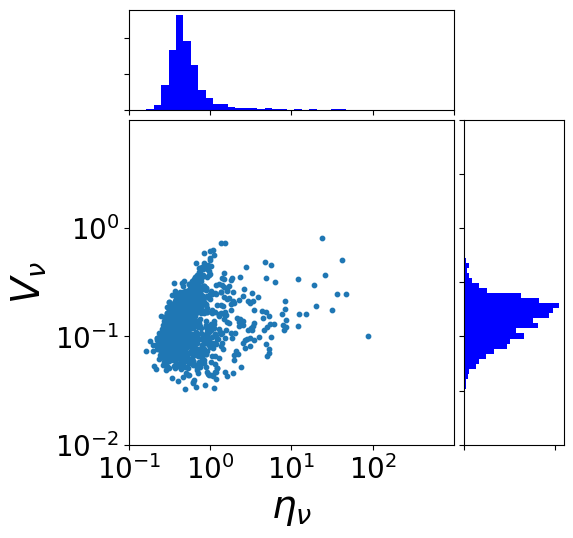

In [128]:
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(5,5))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=28)
plt.ylabel(r'$V_{\nu}$', fontsize=28)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])

xdata_var=np.log10(plotdata['eta'])
ydata_var=np.log10(plotdata['V'])
axScatter.scatter(xdata_var, ydata_var, s=10.)

x = np.log10(plotdata['eta'])
y = np.log10(plotdata['V'])

axHistx.hist(x, bins=30, histtype='stepfilled', color='b')
axHisty.hist(y, bins=30, histtype='stepfilled', orientation='horizontal', color='b')

xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=20)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=20)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())

plt.show()

In the simplest case, we now define variable sources as those that are significantly deviant from the population. i.e. we assume that the majority of sources in the radio sky are not variable. From experience, this is a pretty reasonable assumption.

We fit the &eta; and V distributions with a Gaussian curve. Then we can specify the number of &sigma; deviant we want to use as the threshold [(see Rowlinson et al. 2019 for more info)](https://ui.adsabs.harvard.edu/abs/2019A%26C....27..111R/abstract). Typically, 2&sigma; gives a reasonable result.

In [129]:
sigmaThresh = 2

In [130]:
from scipy.stats import norm

def SigmaFit(data):
    median = np.median(data)
    std_median = np.sqrt(np.mean([(i-median)**2. for i in data]))
    tmp_data = [a for a in data if a < 3.*std_median+median and a > median - 3.*std_median]
    param1 = norm.fit(tmp_data)
    param2 = norm.fit(data)
    return param1, param2

In [131]:
paramx, paramx2 = SigmaFit(np.log10(plotdata['eta']))
paramy, paramy2 = SigmaFit(np.log10(plotdata['V']))

print('Gaussian Fit eta: '+str(round(10.**paramx[0],2))+'(+'+str(round((10.**(paramx[0]+paramx[1])-10.**paramx[0]),2))+' '+str(round((10.**(paramx[0]-paramx[1])-10.**paramx[0]),2))+')')
print('Gaussian Fit V: '+str(round(10.**paramy[0],2))+'(+'+str(round((10.**(paramy[0]+paramy[1])-10.**paramy[0]),2))+' '+str(round((10.**(paramy[0]-paramy[1])-10.**paramy[0]),2))+')')

sigcutx = paramx[1]*sigmaThresh+paramx[0]
sigcuty = paramy[1]*sigmaThresh+paramy[0]

print('eta threshold = '+str(round(10.**sigcutx,2)))
print('V threshold = '+str(round(10.**sigcuty,2)))

Gaussian Fit eta: 0.49(+0.25 -0.17)
Gaussian Fit V: 0.14(+0.08 -0.05)
eta threshold = 1.12
V threshold = 0.35


We can now use these thresholds to identify which sources are variable and illustrate it in the plot.

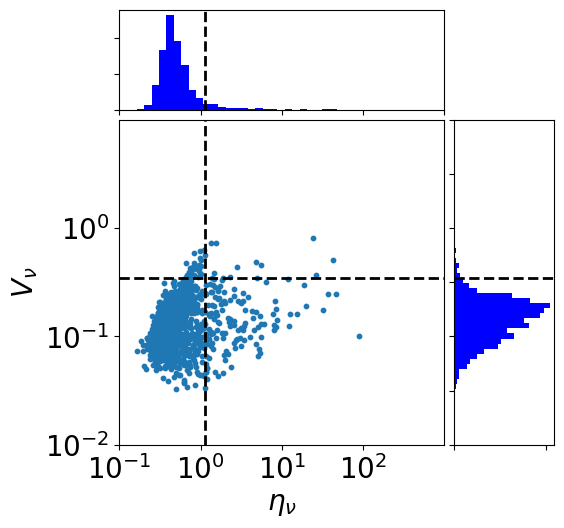

In [132]:

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(5,5))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=20)
plt.ylabel(r'$V_{\nu}$', fontsize=20)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])

xdata_var=np.log10(plotdata['eta'])
ydata_var=np.log10(plotdata['V'])
axScatter.scatter(xdata_var, ydata_var, s=10.)

x = np.log10(plotdata['eta'])
y = np.log10(plotdata['V'])

#axHistx.hist(x, bins=make_bins(x), histtype='stepfilled', color='b')
#axHisty.hist(y, bins=make_bins(y), histtype='stepfilled', orientation='horizontal', color='b')
axHistx.hist(x, bins=30, histtype='stepfilled', color='b')
axHisty.hist(y, bins=30, histtype='stepfilled', orientation='horizontal', color='b')

axHistx.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')
axHisty.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
axScatter.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
axScatter.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')

xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=20)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=20)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())

plt.show()

In [133]:
variables = plotdata.loc[(plotdata['eta']>=10.**sigcutx) & (plotdata['V']>=10.**sigcuty)]
variables

runcat        eta         V    maxFlx    avgFlx        freq  dpts  \
620   109667   2.784498  0.433631  0.001315  0.000637  144.432068    14   
779   109826   4.771098  0.487597  0.001500  0.000672  144.432068    31   
1659  110708   1.456596  0.381600  0.000723  0.000414  144.432068     7   
2316  111365  23.846121  0.815198  0.005340  0.000782  144.432068    40   
4537  113590  26.090231  0.365592  0.004602  0.002358  144.432068    57   
6222  115278   2.305871  0.357408  0.001381  0.000760  144.432068    31   
6538  115595   5.585533  0.456901  0.001955  0.000882  144.432068    39   
7639  116696   1.341196  0.732225  0.000815  0.000228  144.432068     1   
7715  116772   1.525921  0.736184  0.001114  0.000296  144.432068     2   
7763  116820  41.894690  0.508641  0.005306  0.001891  144.432068    57   

     newSrc          ra    ra_err        dec   dec_err  
620       N  245.679943  0.000580  54.488020  0.000337  
779       N  245.512750  0.000579  54.848534  0.000333  
1659      N  244.721491  0.000596  55.183861  0.000340  
2316      N  244.273307  0.000577  55.267033  0.000329  
4537      N  242.819804  0.000537  53.333520  0.000321  
6222      N  241.732834  0.000560  53.279532  0.000335  
6538      N  241.500753  0.000558  53.260541  0.000334  
7639      N  240.463986  0.000616  56.370491  0.000341  
7715      N  240.561573  0.000576  53.238593  0.000345  
7763      N  240.326414  0.000582  56.409506  0.000322

Obviously, the next step is to plot the light curve to confirm the variability visually. Usually we also want to visually inspect to check for artefacts so we will also load the image. Automating this step is underway for some types of artefacts - such as sidelobes of bright sources.

Assuming the images are still available, we can plot the source and its surroundings. To do this, we need to pull the full light curve for the sources out of the database and we need to access three new tables.

In [134]:
def extract_data(fits_file_path, ra, dec, size):    
    hdu = fits.open(fits_file_path)[0]
    data1 = hdu.data
    wmap = WCS(hdu.header, naxis=2)
    data1 = data1[0][0]
    return data1, wmap


def fix_axes_limits_ax1(ax1, RA_coord, DEC_coord, wmap,pix_lim):
    """Define a window of 2*pix_lim around the center coordinate in LoTSS."""
    px, py = wmap.wcs_world2pix(RA_coord, DEC_coord, 1)
    ax1.set_xlim(px-pix_lim, px+pix_lim)
    ax1.set_ylim(py-pix_lim, py+pix_lim)

    RA_min, DEC_min = wmap.wcs_pix2world(px-pix_lim, py-pix_lim, 1)
    RA_max, DEC_max = wmap.wcs_pix2world(px+pix_lim, py+pix_lim, 1)

    return px, py, RA_min, DEC_min, RA_max, DEC_max



Runcat = 109667
245.67994327375536 54.488020260109685


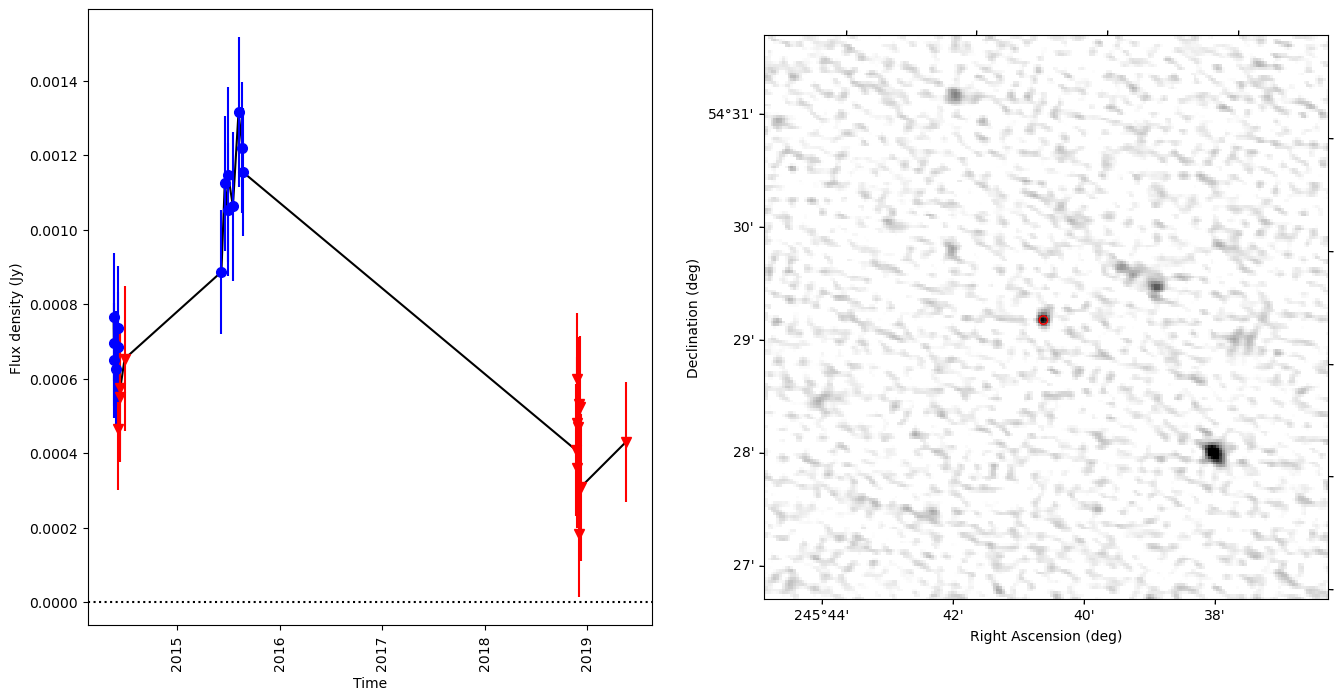

Runcat = 109826
245.5127502832372 54.848533721839324


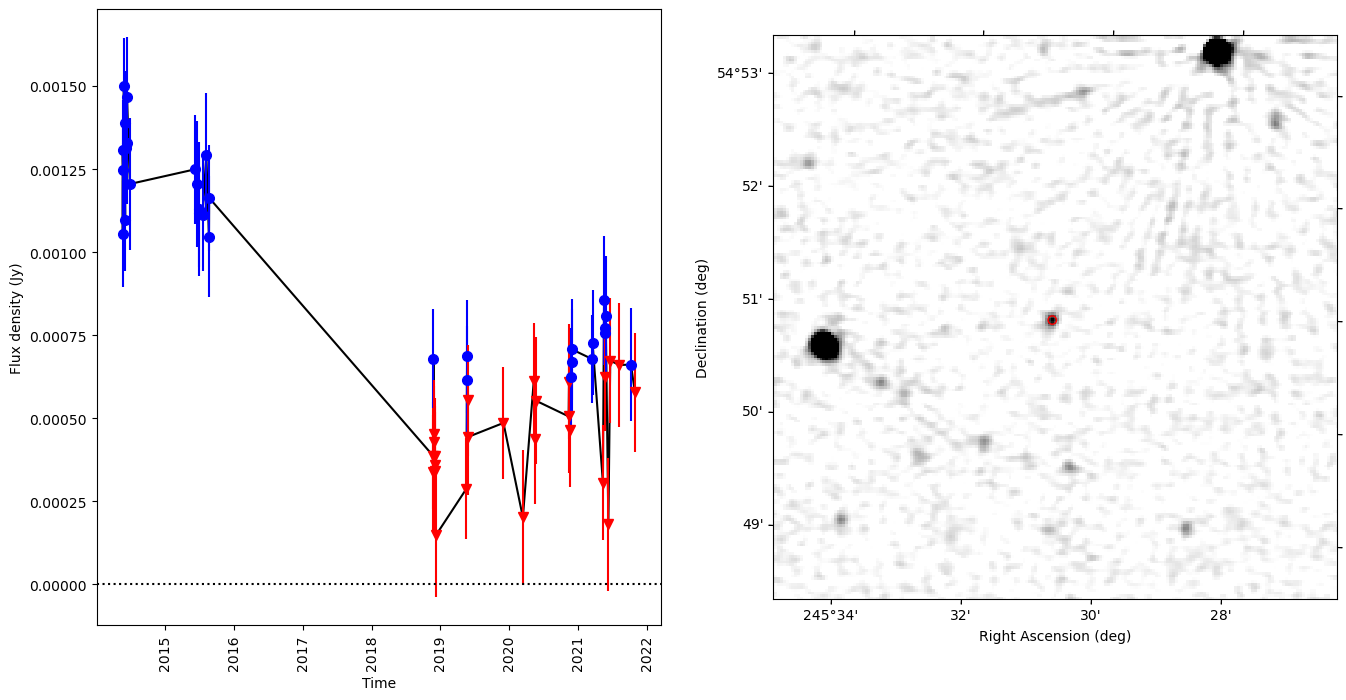

Runcat = 110708
244.72149119157177 55.183861370542914


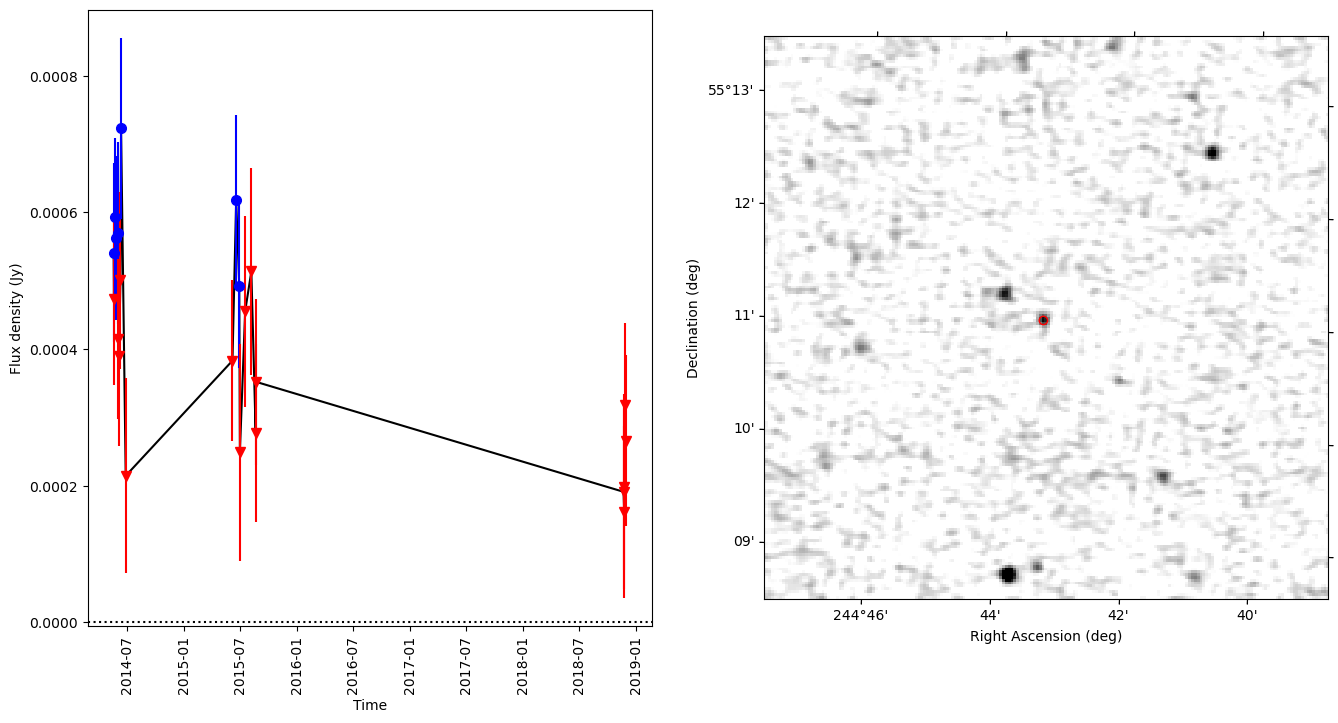

Runcat = 111365
244.2733074812661 55.26703293236653


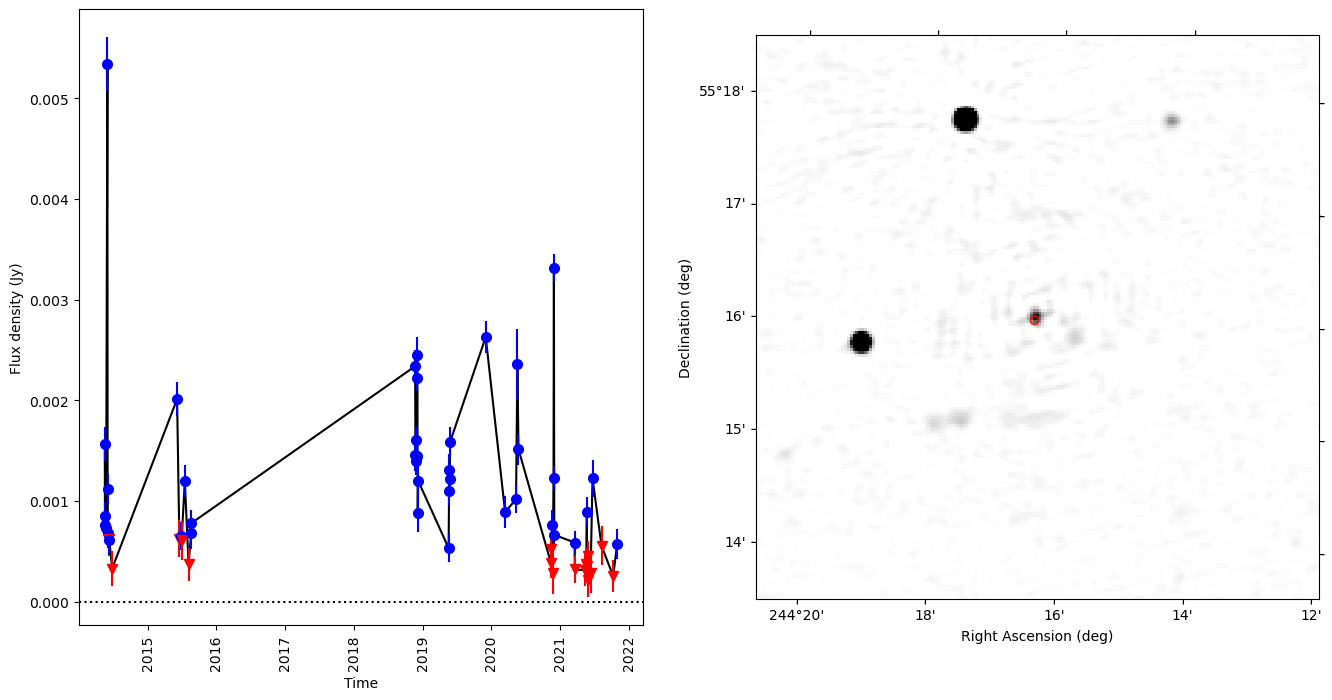

Runcat = 113590
242.81980395569568 53.33351970288101


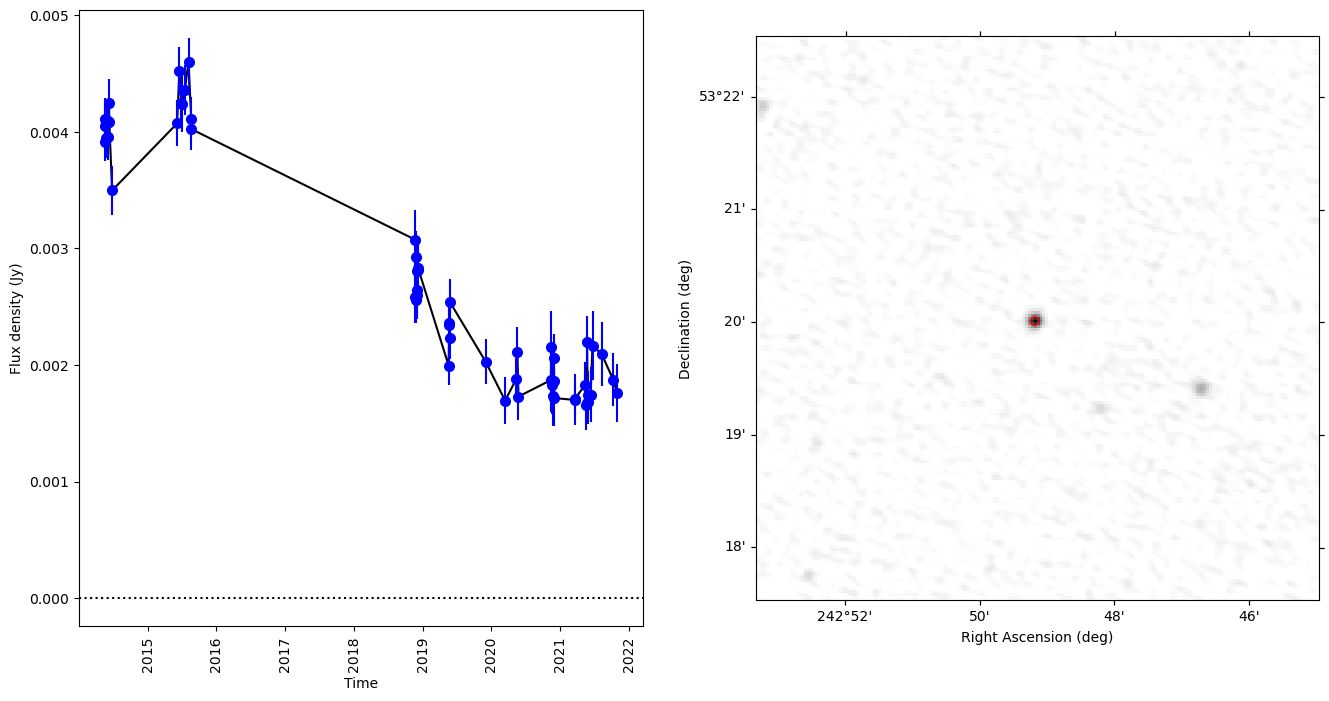

Runcat = 115278
241.7328335112149 53.27953191184821


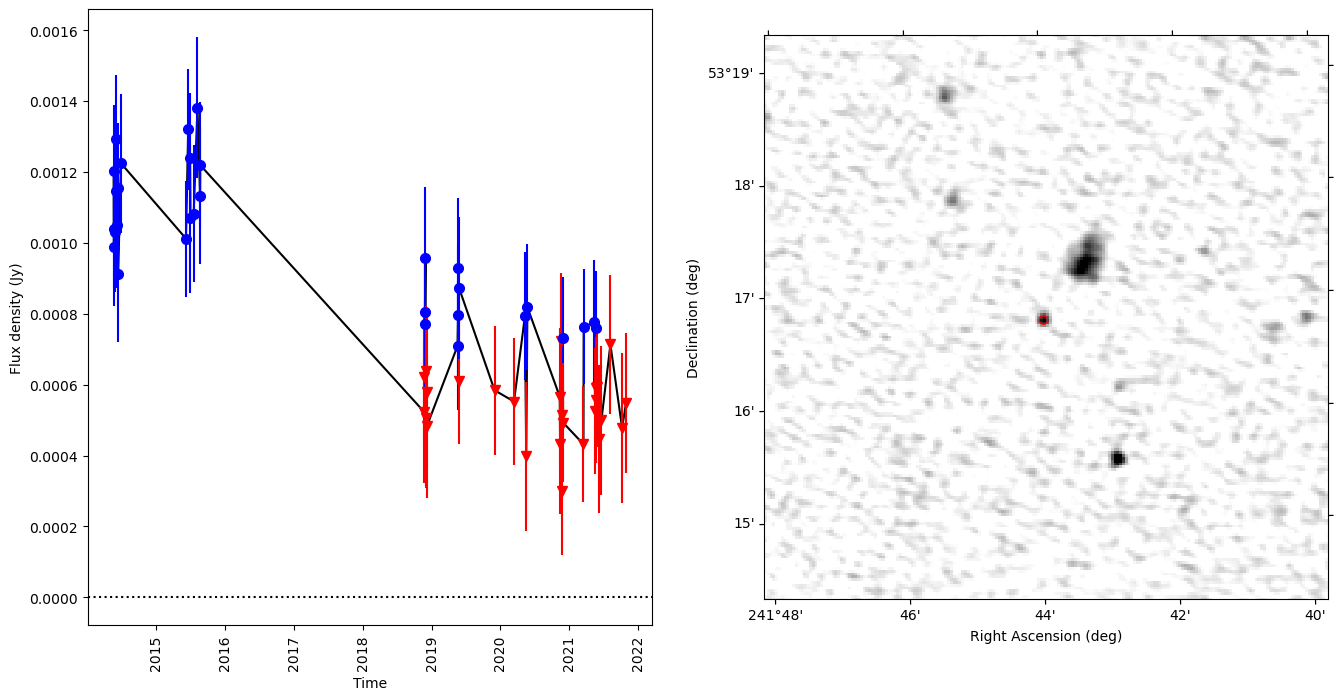

Runcat = 115595
241.50075255769266 53.260540546861904


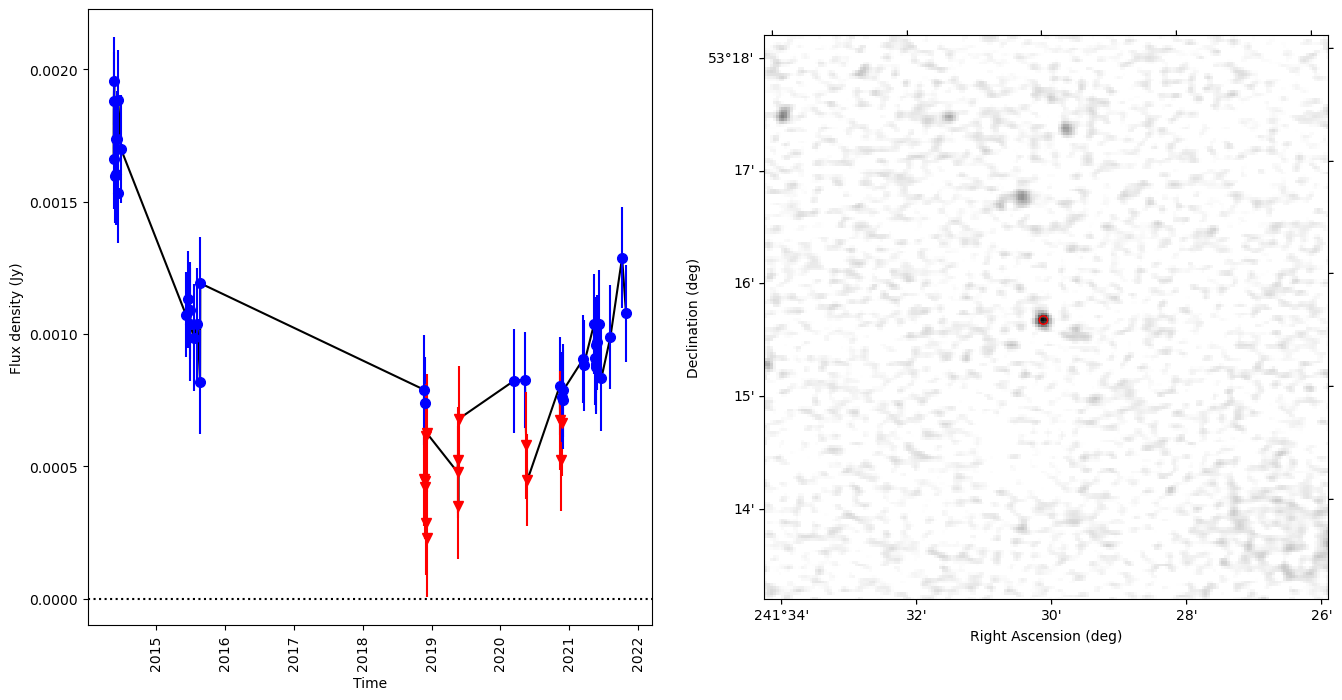

Runcat = 116696
240.46398588731327 56.370490754142004


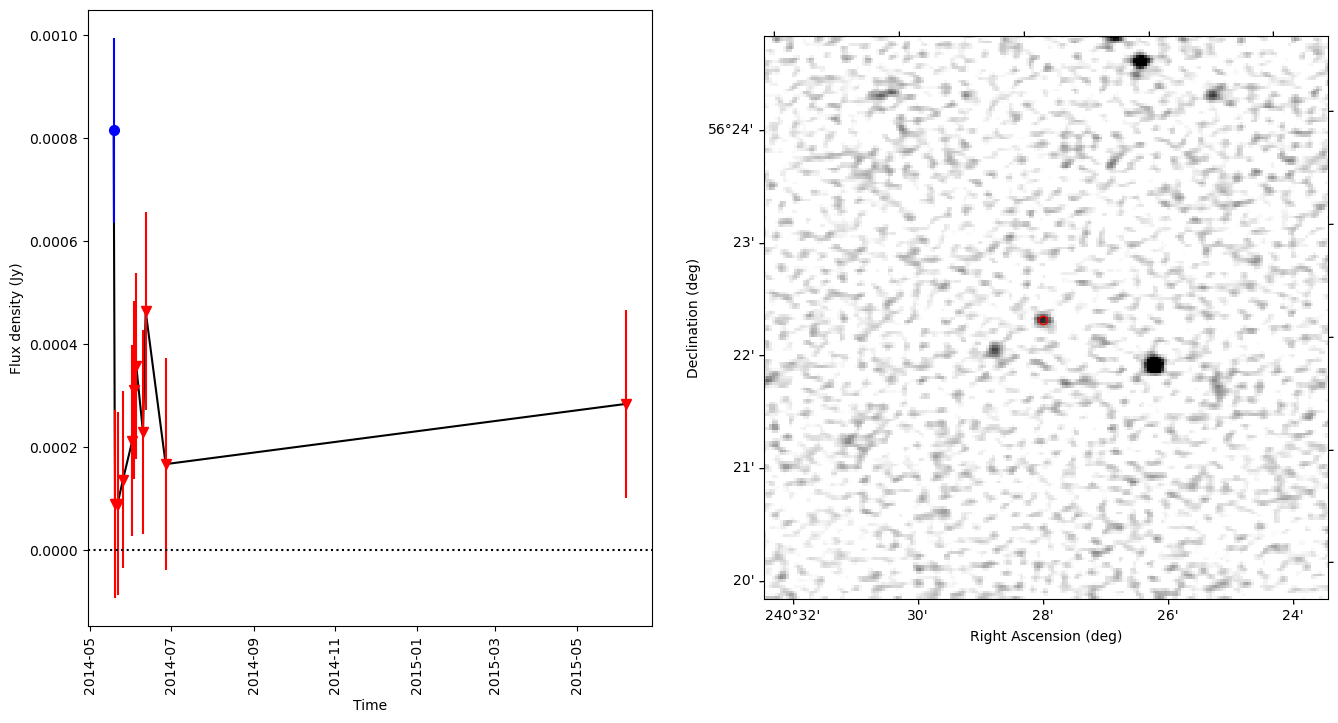

Runcat = 116772
240.56157258558065 53.23859269808058


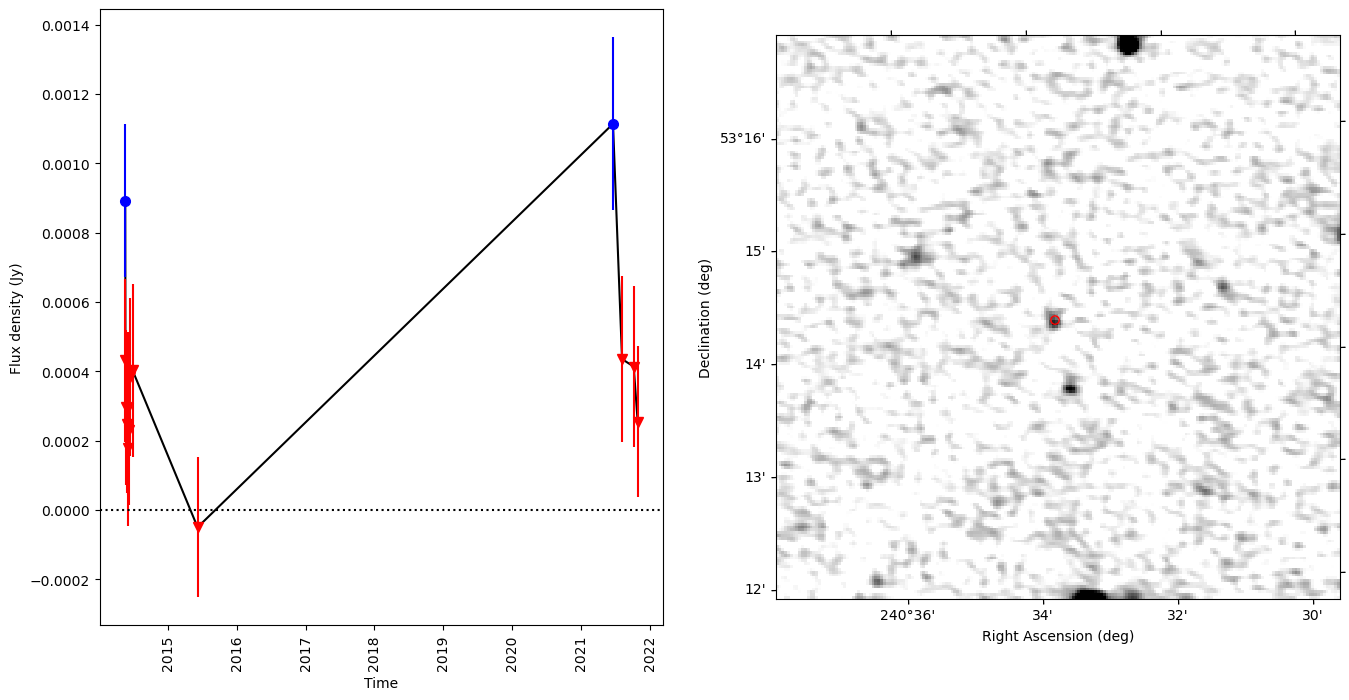

Runcat = 116820
240.32641447601648 56.40950555601131


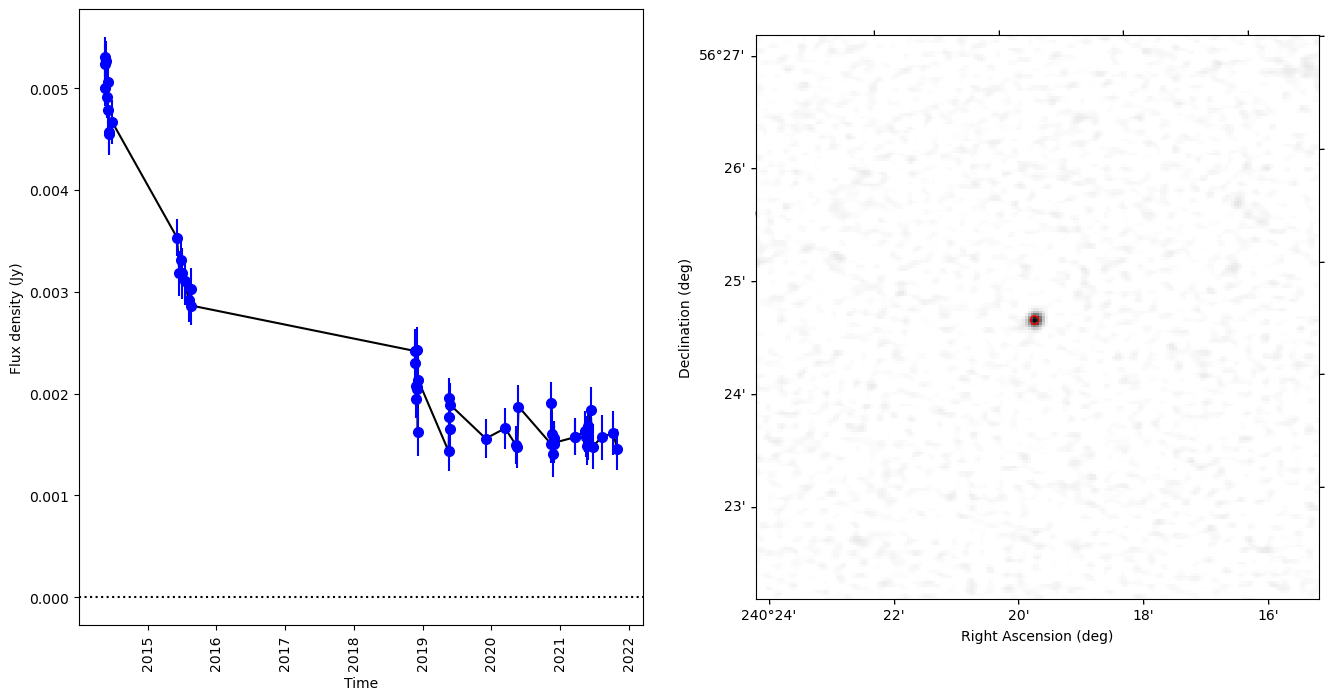

/tmp/ipykernel_582560/1635185340.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['maxImg']=maxImgs


In [135]:
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Ellipse

size = 100
maxImgs=[]
for index, row in variables.iterrows():
    sourceID = row.runcat
    flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type, flxVals[x].Extractedsource.reduced_chisq] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type','rchisq'])
    lightcurve = pd.merge(lightcurve, images, on="Image")

    print('Runcat = '+str(sourceID))
    print(row.ra,row.dec)
    #print(max(lightcurve.rchisq))
    
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.type==0:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.type==1:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    maxFlux = np.max(lightcurve.Flux)
    maxFluxImg = lightcurve.loc[lightcurve.Flux==maxFlux]
    maxImgs.append(maxFluxImg.iloc[0].Image)


    
    extractedData, wcs = extract_data(maxFluxImg.iloc[0].Image,row.ra,row.dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()

    #for index2, row2 in lightcurve.iterrows():
    #    print(row2.Image)

variables['maxImg']=maxImgs


Once you've confirmed the transient candidate is not an artefact, it is useful to determine if there is an associated known source at the location. To do this, we typically query [Simbad](https://simbad.u-strasbg.fr/simbad/) and this can be done automatically within Python.

In [136]:
from astroquery.simbad import Simbad
import astropy.coordinates as coord

searchRadius = 10. # in arcsec
searchRadius = (searchRadius/3600.)*u.deg

for index, row in variables.iterrows():
    sourceID = row.runcat
    print('Runcat = '+str(sourceID)+' position error = '+str(max(row.ra_err,row.dec_err)*3600)+' arcsec')
    result_table = Simbad.query_region(coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
    srcPos=coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5')
    if result_table:
        results = [[row['MAIN_ID'], row['RA'], row['DEC'], srcPos.separation(SkyCoord(str(row['RA'])+' '+str(row['DEC']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
        results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
        print(results)
    else:
        print('no matches')
    

Runcat = 109667 position error = 2.086643100952826 arcsec
                         ID            ra           dec  separation
0  SDSS J162243.17+542916.3  16 22 43.173  +54 29 16.37    0.502306
Runcat = 109826 position error = 2.083944589936538 arcsec
no matches
Runcat = 110708 position error = 2.146120734393924 arcsec
no matches
Runcat = 111365 position error = 2.077915873883948 arcsec


            ID             ra            dec  separation
0  BD+55  1823  16 17 05.3518  +55 16 08.771     7.74776
Runcat = 113590 position error = 1.934610599665045 arcsec
no matches
Runcat = 115278 position error = 2.016852036900685 arcsec
no matches
Runcat = 115595 position error = 2.008054805472323 arcsec


             ID          ra        dec  separation
0  LEDA 2436071  16 06 00.1  +53 15 37      1.1806
Runcat = 116696 position error = 2.2171556279934306 arcsec
no matches
Runcat = 116772 position error = 2.0729006717729614 arcsec
no matches
Runcat = 116820 position error = 2.0952553801770706 arcsec
                    ID            ra           dec  separation
0  NVSS J160117+562434  16 01 18.276  +56 24 33.83    0.649624


Write a ds9 regions file

In [137]:
with open('ds'+str(dataset_id)+'_variable1_regions.reg', 'w') as f:
    f.write('# Region file format: DS9 version 4.1 \n')
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
    f.write('fk5 \n')
    for index, row in variables.iterrows():
        f.write('circle('+str(row.ra)+','+str(row.dec)
                    +',10") # text={'+str(row.runcat)+'} \n')
    f.close()


### Variability Searches - version 2

We have noticed that the variability parameters we use show a correlation with the maximum flux density of the source. We show this correlation here:

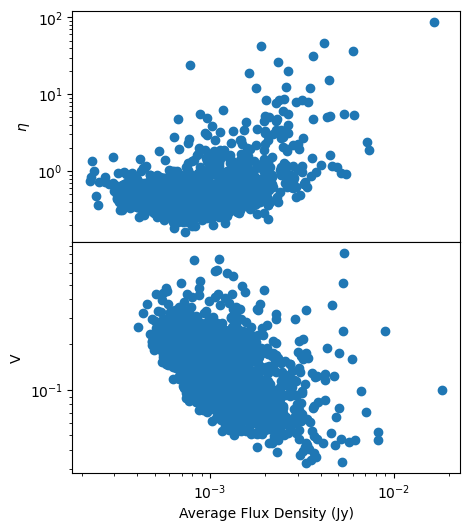

In [138]:
fig = plt.figure(figsize=(5, 6))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
axs[0].scatter(plotdata.avgFlx,plotdata.eta)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel(r'$\eta$')
axs[1].scatter(plotdata.maxFlx,plotdata.V)
axs[1].set_yscale('log')
#axs[1].set_xscale('log')
axs[1].set_ylabel('V')
axs[1].set_xlabel('Average Flux Density (Jy)')
for ax in axs:
    ax.label_outer()

Recent work by [Valdata et al. (in prep)]() takes into account this correlation. It fits the distribution with a linear function and then determines the distances of each data point from the correlation. As we only care about variable sources, we only select the sources that lie above the correlation. We convert to using the log10 values of the variability parameters and flux densities to simplify the code. In the following, we show a simplified version of the code - please refer to the [GitHub repository](https://github.com/ruggerovaldata/Separating-Candidate-Transients/tree/main) for the main code.

In [139]:
plotdata['logEta'] = plotdata.apply(lambda row: np.log10(row.eta), axis=1)
plotdata['logV'] = plotdata.apply(lambda row: np.log10(row.V), axis=1)
plotdata['logFlux'] = plotdata.apply(lambda row: np.log10(row.maxFlx), axis=1)

/tmp/ipykernel_582560/1269240526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['logEta'] = plotdata.apply(lambda row: np.log10(row.eta), axis=1)
/tmp/ipykernel_582560/1269240526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['logV'] = plotdata.apply(lambda row: np.log10(row.V), axis=1)
/tmp/ipykernel_582560/1269240526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

We import the scripts used by Valdata et al. (in prep).

In [140]:
import myplotting as myplt
import functions as func

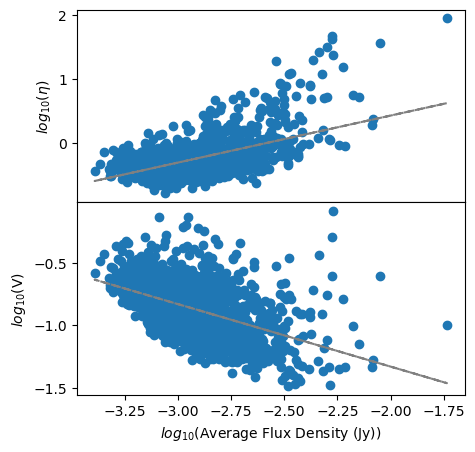

In [141]:
import scipy.optimize as spopt
import scipy.stats as spstat

freq = plotdata.freq.unique()
#Finding the line that best represents the two parameters of the data
best_params_eta, ml_cfcovar_linear = spopt.curve_fit(func.LinearFit, plotdata.logFlux, plotdata.logEta)
best_params_V, ml_cfcovar_linear = spopt.curve_fit(func.LinearFit, plotdata.logFlux, plotdata.logV)

m_eta, q_eta = best_params_eta[0],best_params_eta[1]
m_V, q_V = best_params_V[0],best_params_V[1]
y_eta = func.LinearFit(plotdata.logFlux,m_eta,q_eta)
y_V = func.LinearFit(plotdata.logFlux,m_V,q_V)

fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
axs[0].scatter(plotdata.logFlux,plotdata.logEta)
axs[0].set_ylabel(r'$log_{10}$($\eta$)')
axs[0].plot(plotdata.logFlux,y_eta,label='Best fit',color='gray', ls='--')
axs[1].scatter(plotdata.logFlux,plotdata.logV)
axs[1].set_ylabel(r'$log_{10}$(V)')
axs[1].set_xlabel(r'$log_{10}$(Average Flux Density (Jy))')
axs[1].plot(plotdata.logFlux,y_V,label='Best fit',color='gray',ls='--')
for ax in axs:
    ax.label_outer()


Now we extract only the data points that lie above this line.

In [142]:
#Calculating the paramater distance from the line that has been found earlier
plotdata['distsEta'] = plotdata.apply(lambda row: func.Params_distance(row.logEta,func.LinearFit(row.logFlux,m_eta,q_eta)), axis=1)
plotdata['distsV'] = plotdata.apply(lambda row: func.Params_distance(row.logV,func.LinearFit(row.logFlux,m_V,q_V)), axis=1)

dataBest = plotdata.loc[(plotdata['distsEta'] > 0) & (plotdata['distsV'] > 0)]

/tmp/ipykernel_582560/3910120889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['distsEta'] = plotdata.apply(lambda row: func.Params_distance(row.logEta,func.LinearFit(row.logFlux,m_eta,q_eta)), axis=1)
/tmp/ipykernel_582560/3910120889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata['distsV'] = plotdata.apply(lambda row: func.Params_distance(row.logV,func.LinearFit(row.logFlux,m_V,q_V)), axis=1)


Now plot the distances from the two lines and fit a multivariate normal distribution to the data. We can then use this fit to determine which sources are outliers to the distribution.

/tmp/ipykernel_582560/452078645.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataBest['probability'] = 100.-outliers_prob


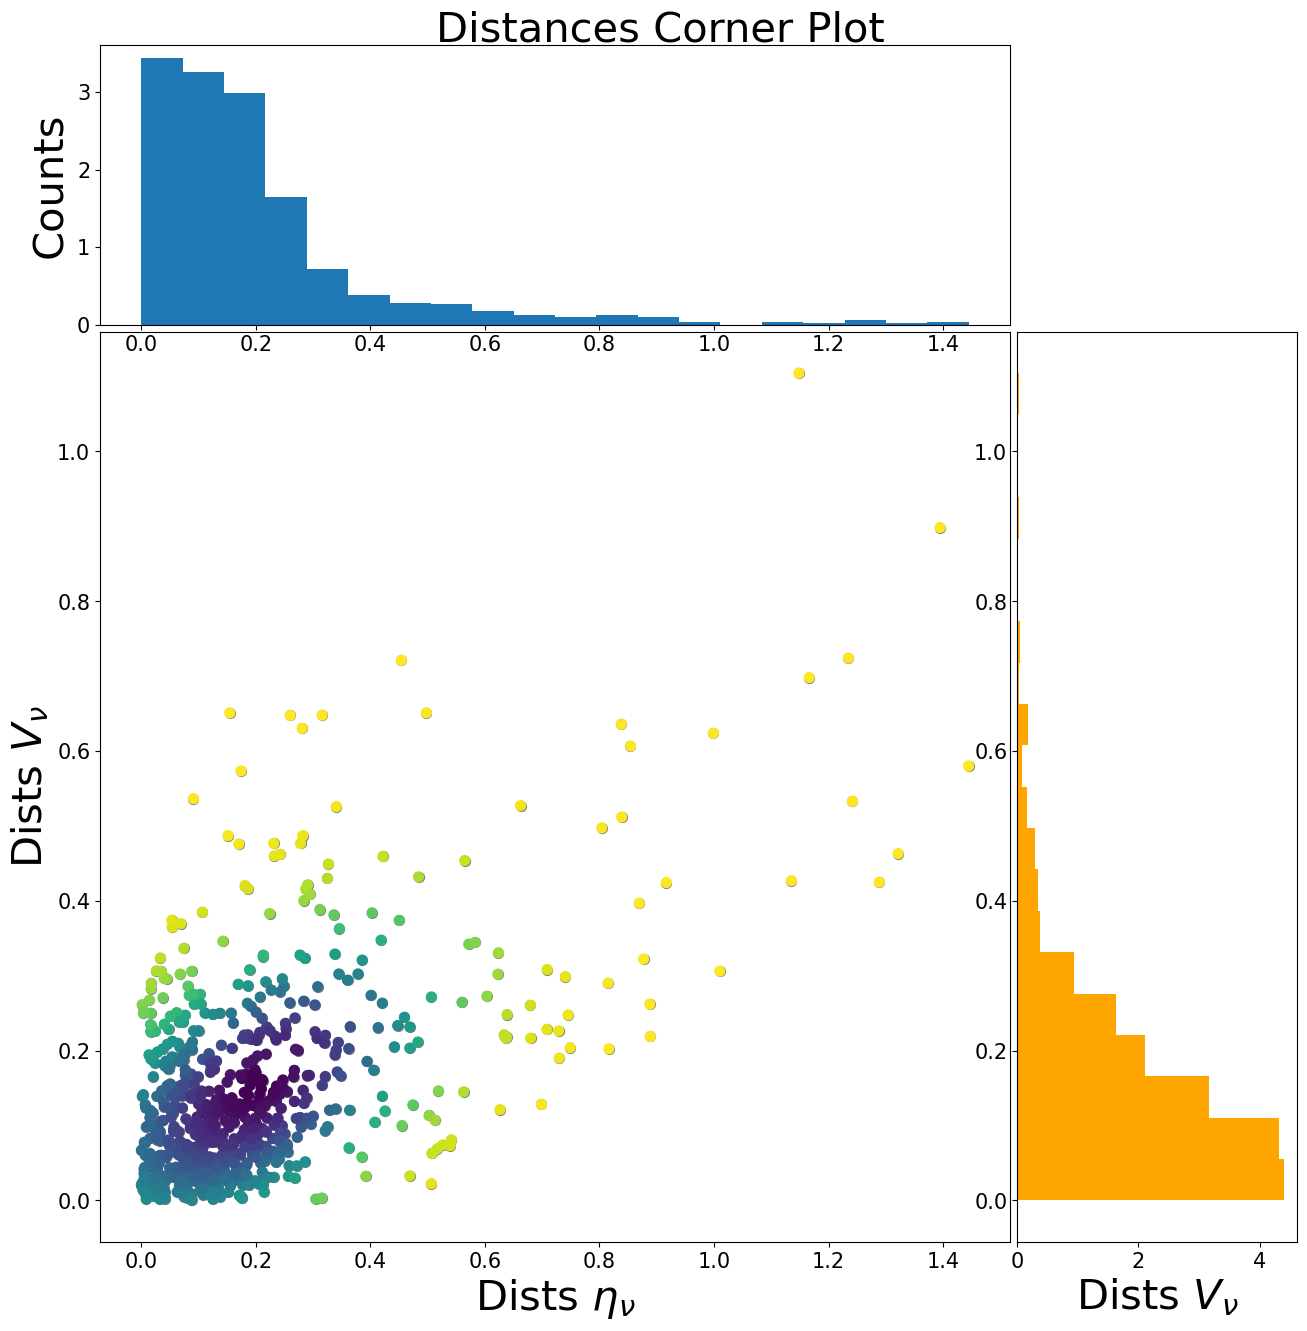

In [143]:
p = 0.99 #Inserting here the percentage with which the source should be classified as inlier

data_graph = np.vstack([dataBest.distsEta,dataBest.distsV])
data_graph = data_graph.T

mean_deta = np.mean(dataBest.distsEta)
mean_dV = np.mean(dataBest.distsV)
mu = [mean_deta,mean_dV]

cov_matrix = np.cov(dataBest.distsEta,dataBest.distsV)
likelihood = spstat.multivariate_normal.pdf(data_graph,[mean_deta,mean_dV],cov_matrix)

outliers_prob = func.Probability(data_graph,mu,cov_matrix) #Calculating the probability for every parameter of being associated to an "inlier" source

dataBest['probability'] = 100.-outliers_prob
temp = dataBest.sort_values('probability')
dataBest.to_csv('WholedatasetoutputBest.csv', index=False)

figure, axes = myplt.MyCorner(dataBest.distsEta,dataBest.distsV,dataBest.probability/100.,'CornerPlotBest') #Printing the corner plot both with the likelihood and without the likelihood

chi2 = spstat.chi2.ppf([p],2)[0]

# finding the outliers with probabilities >99% and with positive distances abovve the trend line
inliersBest = dataBest.loc[ (dataBest['probability'] <= p*100.) ]
outliersBest = dataBest.loc[ (dataBest['probability'] > p*100.) ]


Text(125.97222222222221, 0.5, '$log_{10}(V_{\\nu})$')

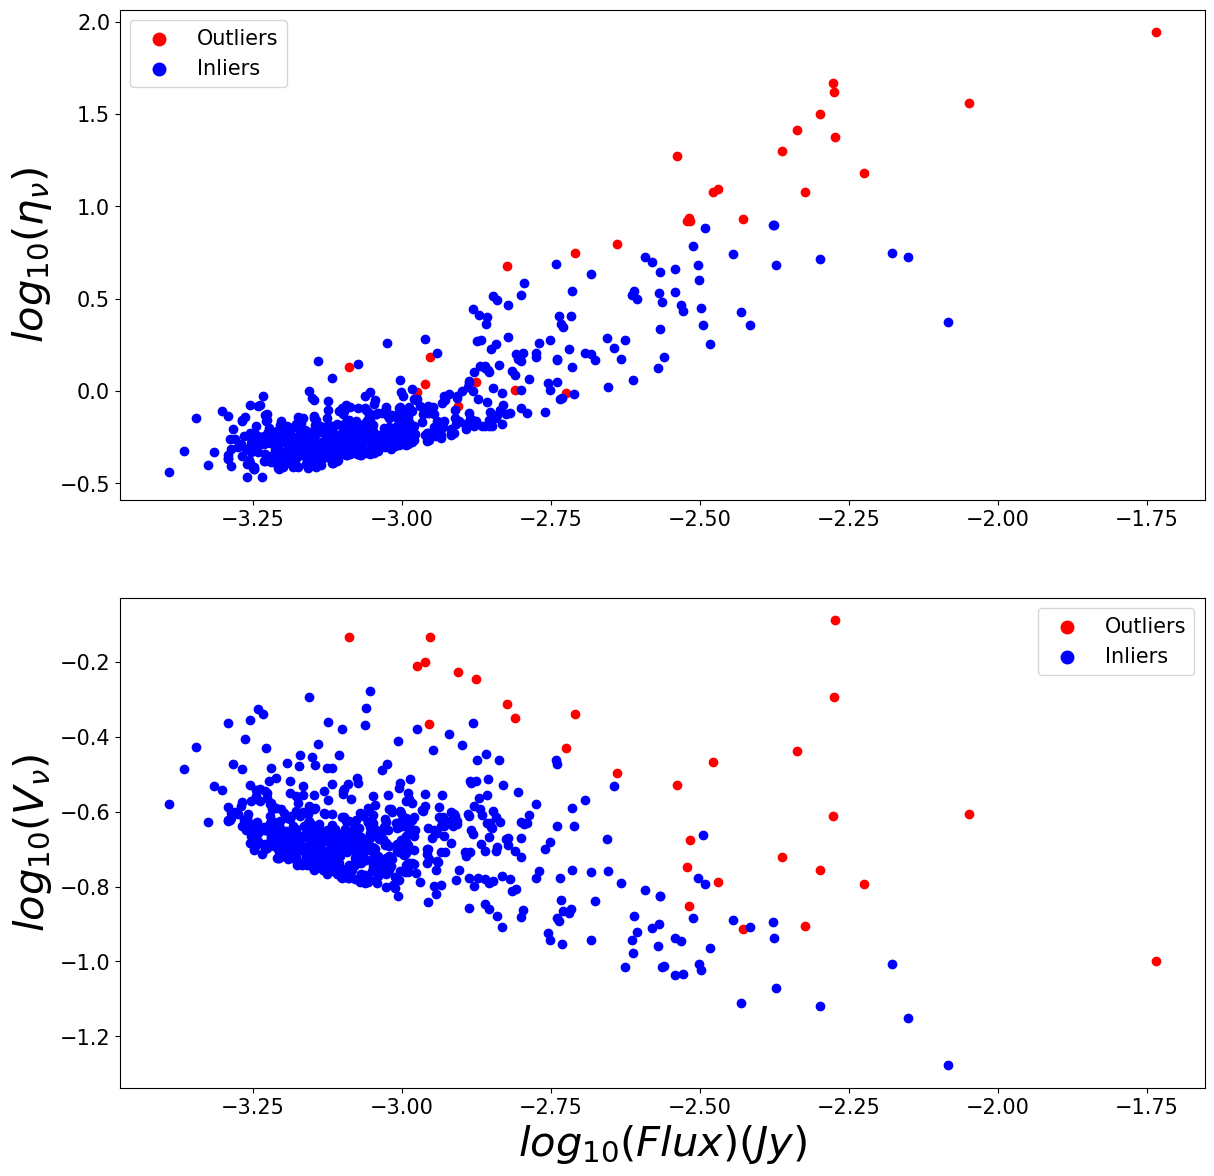

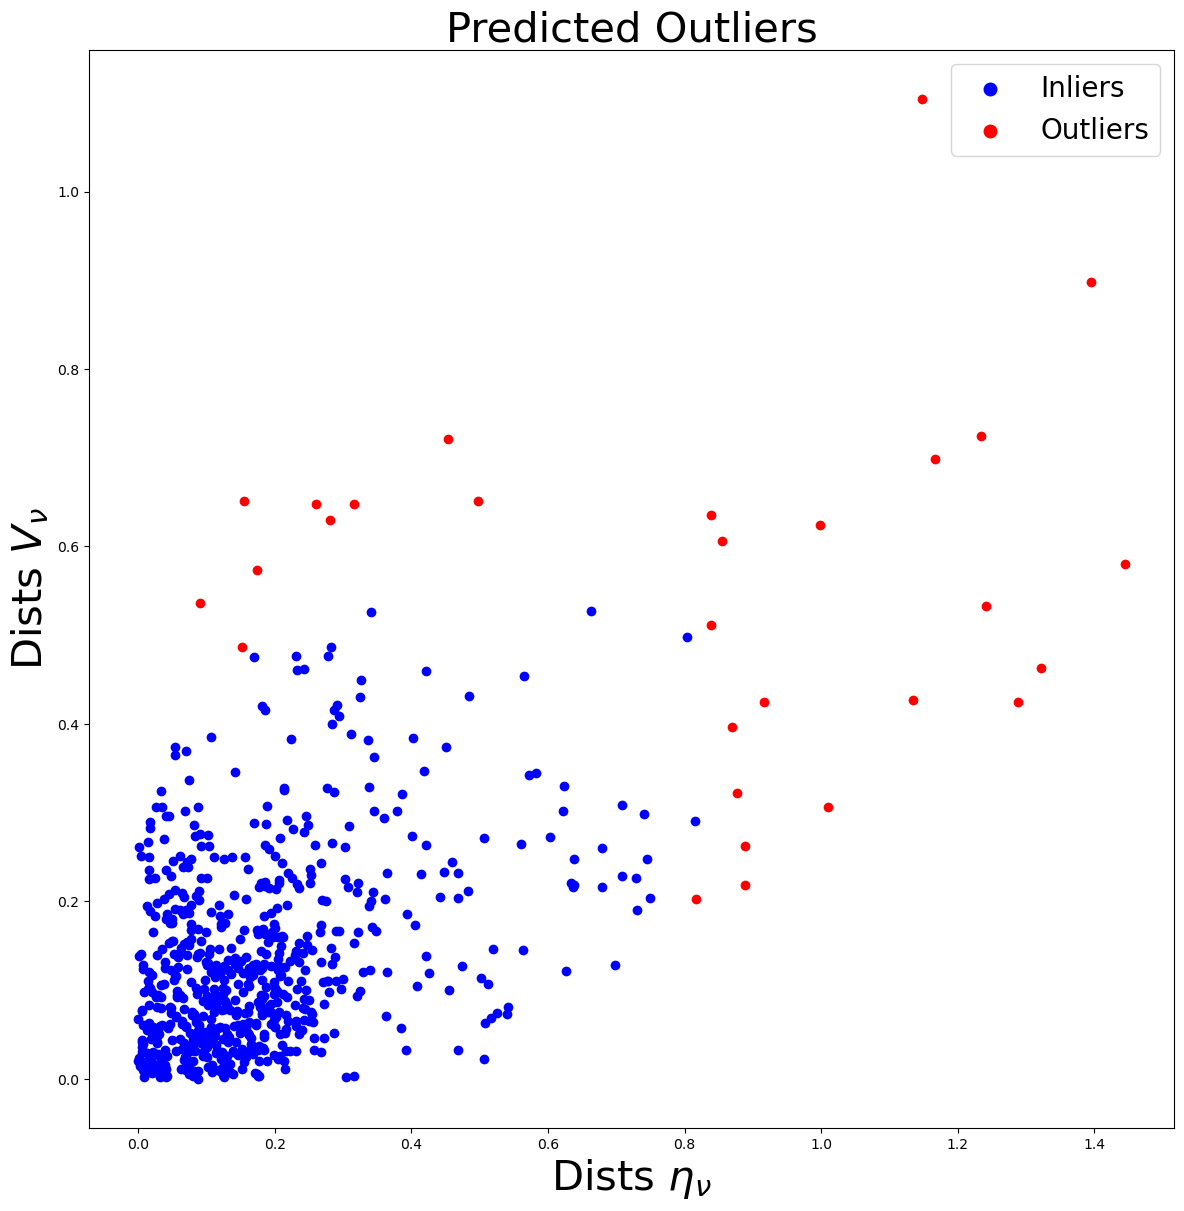

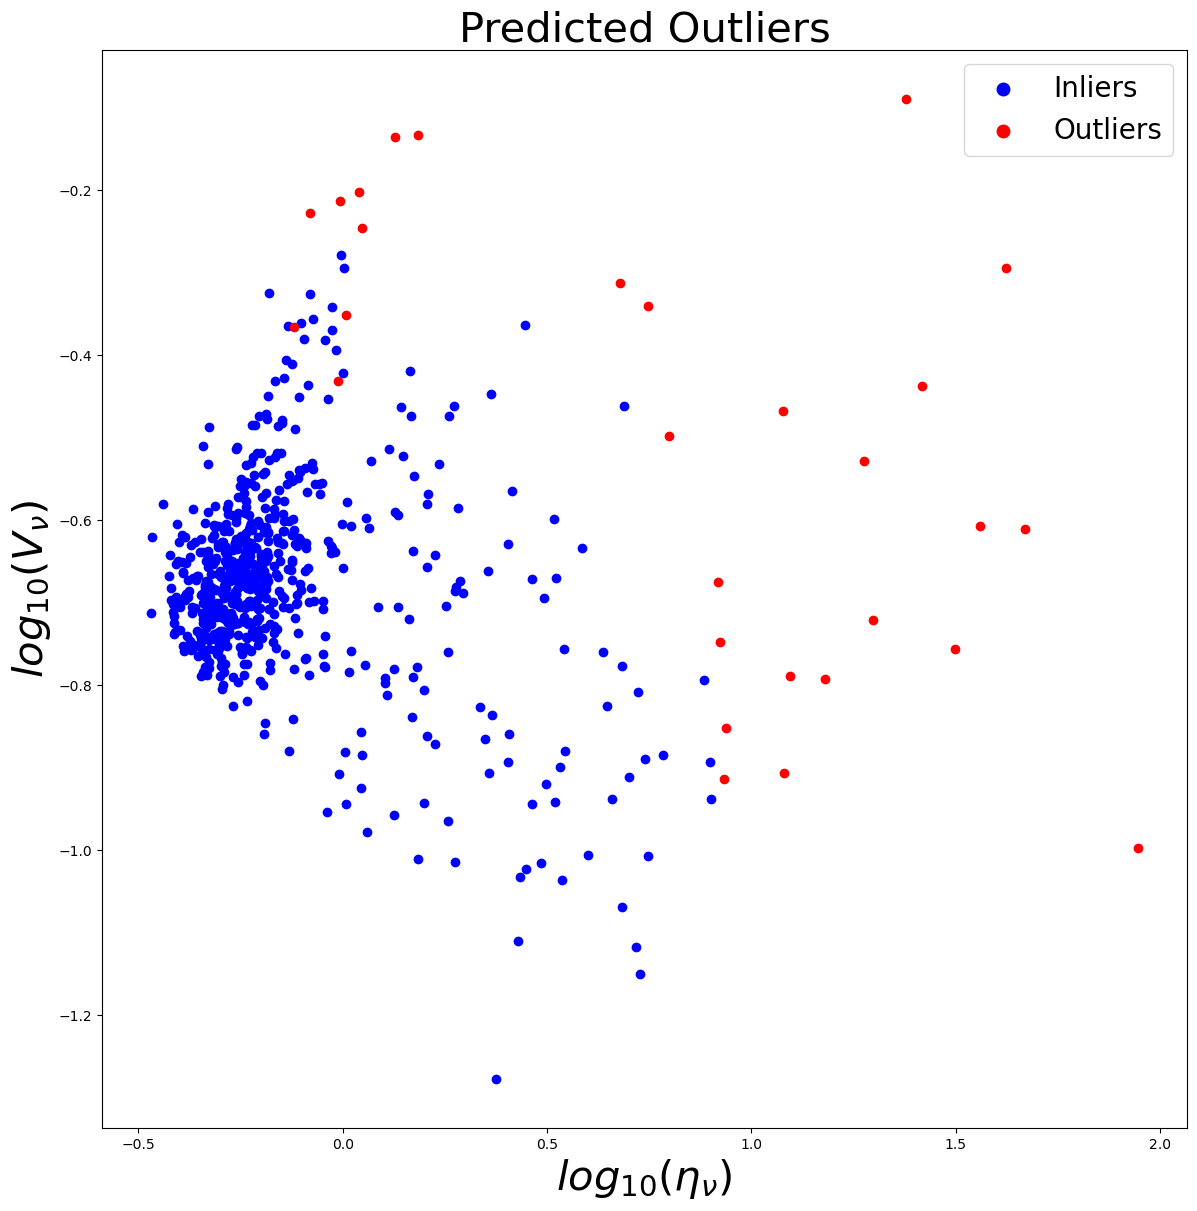

In [144]:
# Plotting
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,14))

ax1.scatter(outliersBest.logFlux,outliersBest.logEta,color='red',label='Outliers')
ax1.scatter(inliersBest.logFlux,inliersBest.logEta,color='blue',label='Inliers')
ax2.scatter(outliersBest.logFlux,outliersBest.logV,color='red',label='Outliers')
ax2.scatter(inliersBest.logFlux,inliersBest.logV,color='blue',label = 'Inliers')

ax1.set_ylabel(r'$log_{10}(\eta_{\nu}$)',fontsize=30)
ax2.legend(fontsize=15,markerscale=1.5)
ax1.legend(fontsize=15,markerscale=1.5)
ax2.set_ylabel(r'$log_{10}(V_{\nu}$)',fontsize=30)
ax2.set_xlabel(r'$log_{10}(Flux) (Jy)$',fontsize=30)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
plt.savefig('EtavsVscatterinoutBest')

figure,ax = myplt.OutInPlot(np.array([outliersBest.distsEta, outliersBest.distsV]).T,np.array([inliersBest.distsEta,inliersBest.distsV]).T,'OutIn_UnstableBest')
EtaVsVout, axveta = myplt.OutInPlot(np.array([outliersBest.logEta, outliersBest.logV]).T,np.array([inliersBest.logEta,inliersBest.logV]).T,'OutInEtavsVBest')
axveta.set_xlabel(r'$log_{10}(\eta_{\nu})$',fontsize=30)
axveta.set_ylabel(r'$log_{10}(V_{\nu})$',fontsize=30)


In [145]:
# Outputting variable candidates
print('Number of outliers : ', len(outliersBest))

if len(outliersBest) == 0:
    print('No candidate variable sources found.')
else:
    print(outliersBest.runcat)

Number of outliers :  29
94      109140
172     109218
479     109526
592     109639
779     109826
1242    110291
1268    110317
2316    111365
2862    111912
2878    111928
2979    112029
3079    112130
3662    112714
4288    113341
4537    113590
4714    113769
4735    113790
5572    114628
5984    115040
6538    115595
6910    115967
7072    116129
7639    116696
7715    116772
7763    116820
7823    116880
7962    117019
8197    117256
8205    117264
Name: runcat, dtype: int64


Now we can look at the light curves and images as with the previous variability searches.

In [146]:
variables = outliersBest
#variables = pd.merge(variables,positions,how='inner', on='runcat')
variables

runcat        eta         V    maxFlx    avgFlx        freq  dpts  \
94    109140   0.829832  0.592756  0.001244  0.000534  144.432068     1   
172   109218   0.757884  0.430427  0.001109  0.000477  144.432068     2   
479   109526  15.177450  0.161148  0.005962  0.004417  144.432068    57   
592   109639   6.283534  0.317445  0.002292  0.001173  144.432068    57   
779   109826   4.771098  0.487597  0.001500  0.000672  144.432068    31   
1242  110291   1.113088  0.568277  0.001333  0.000429  144.432068     2   
1268  110317   1.092938  0.628446  0.001091  0.000439  144.432068     1   
2316  111365  23.846121  0.815198  0.005340  0.000782  144.432068    40   
2862  111912   8.389518  0.179001  0.003012  0.002023  144.432068    57   
2878  111928   8.549243  0.121974  0.003739  0.003155  144.432068    57   
2979  112029  12.439581  0.162506  0.003394  0.002593  144.432068    57   
3079  112130  31.585278  0.175488  0.005038  0.003632  144.432068    57   
3662  112714  12.026864  0.124104  0.004755  0.003505  144.432068    57   
4288  113341  46.817863  0.244950  0.005282  0.004149  144.432068    57   
4537  113590  26.090231  0.365592  0.004602  0.002358  144.432068    57   
4714  113769  36.364236  0.247011  0.008964  0.006033  144.432068    57   
4735  113790   8.666252  0.140582  0.003034  0.002515  144.432068    57   
5572  114628  11.936712  0.341162  0.003323  0.001790  144.432068    57   
5984  115040  19.866774  0.189932  0.004339  0.002669  144.432068    57   
6538  115595   5.585533  0.456901  0.001955  0.000882  144.432068    39   
6910  115967   0.972066  0.370525  0.001882  0.001071  144.432068    13   
7072  116129  18.868684  0.296608  0.002895  0.001628  144.432068    57   
7639  116696   1.341196  0.732225  0.000815  0.000228  144.432068     1   
7715  116772   1.525921  0.736184  0.001114  0.000296  144.432068     2   
7763  116820  41.894690  0.508641  0.005306  0.001891  144.432068    57   
7823  116880   0.985725  0.612904  0.001058  0.000338  144.432068     1   
7962  117019   8.305875  0.211456  0.003043  0.002378  144.432068    57   
8197  117256  88.197890  0.100446  0.018411  0.016573  144.432068    57   
8205  117264   1.018324  0.445222  0.001545  0.000633  144.432068     3   

     newSrc          ra    ra_err        dec   dec_err    logEta      logV  \
94        N  246.530014  0.000592  53.910948  0.000349 -0.081010 -0.227124   
172       N  246.365307  0.000595  54.214663  0.000348 -0.120397 -0.366100   
479       N  245.929591  0.000558  55.317670  0.000317  1.181199 -0.792776   
592       N  245.734682  0.000566  54.711827  0.000327  0.798204 -0.498331   
779       N  245.512750  0.000579  54.848534  0.000333  0.678618 -0.311939   
1242      N  244.960606  0.000574  53.094052  0.000345  0.046529 -0.245440   
1268      N  244.935298  0.000576  53.005137  0.000347  0.038596 -0.201732   
2316      N  244.273307  0.000577  55.267033  0.000329  1.377418 -0.088737   
2862      N  243.917381  0.000563  55.509045  0.000319  0.923737 -0.747144   
2878      N  243.868527  0.000543  54.222081  0.000317  0.931928 -0.913733   
2979      N  243.829980  0.000551  54.812015  0.000318  1.094806 -0.789131   
3079      N  243.757648  0.000551  54.861273  0.000317  1.499485 -0.755753   
3662      N  243.375885  0.000564  55.801141  0.000317  1.080152 -0.906213   
4288      N  242.968188  0.000540  54.025918  0.000317  1.670412 -0.610923   
4537      N  242.819804  0.000537  53.333520  0.000321  1.416478 -0.437003   
4714      N  242.703102  0.000580  56.772952  0.000318  1.560674 -0.607283   
4735      N  242.692191  0.000546  54.391317  0.000318  0.937831 -0.852071   
5572      N  242.118349  0.000593  56.902561  0.000324  1.076885 -0.467039   
5984      N  241.883908  0.000545  54.373219  0.000317  1.298127 -0.721401   
6538      N  241.500753  0.000558  53.260541  0.000334  0.747065 -0.340178   
6910      N  241.082465  0.000633  57.265562  0.000342 -0.012304 -0.431182   
7072      N  241.038031  0.000562  55.3

Runcat = 109140
246.53001383327924 53.9109482362478


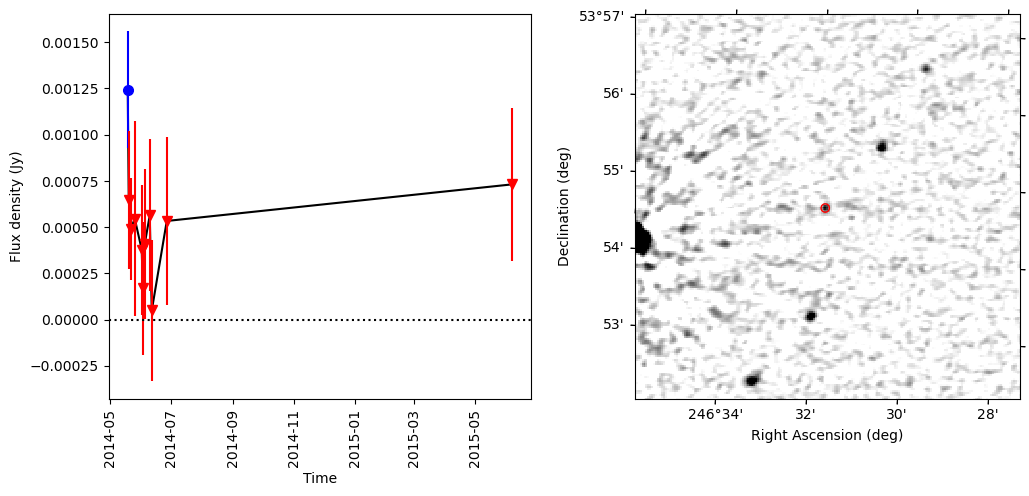

Runcat = 109218
246.3653074426725 54.21466314138748


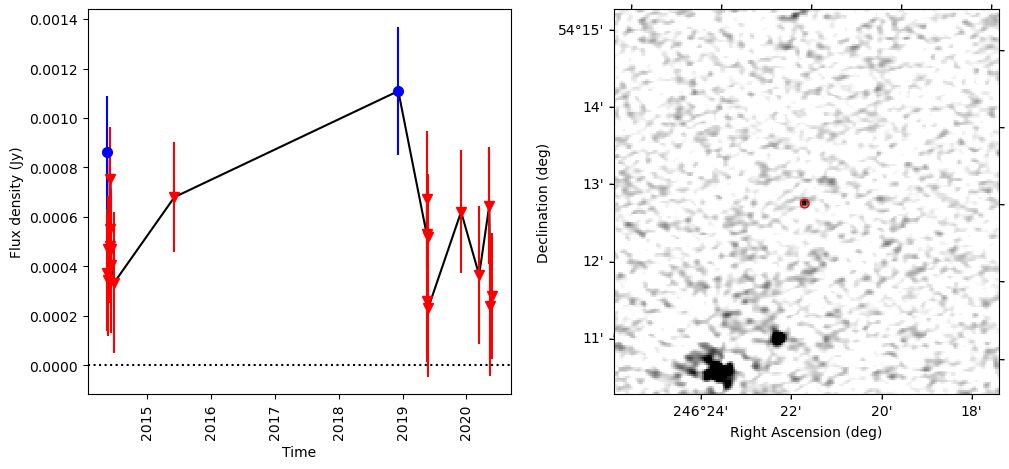

Runcat = 109526
245.9295909762151 55.31767026318477


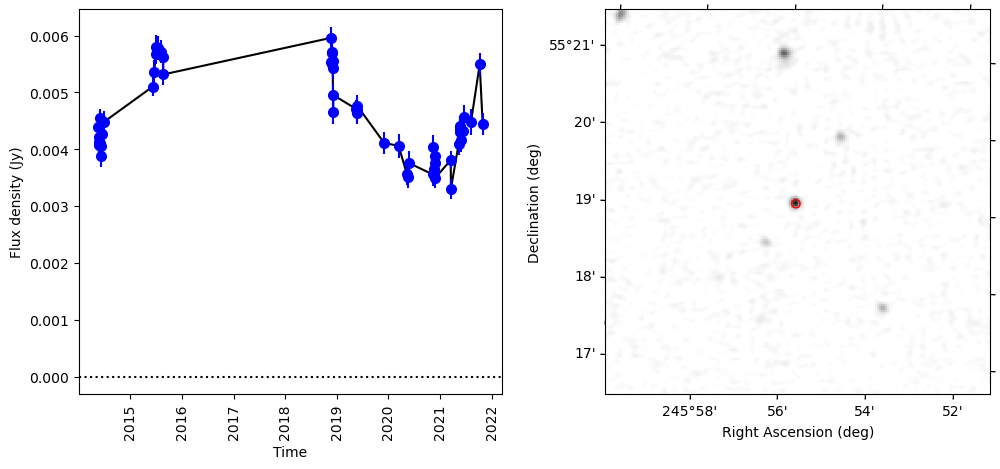

Runcat = 109639
245.73468244041993 54.71182663720913


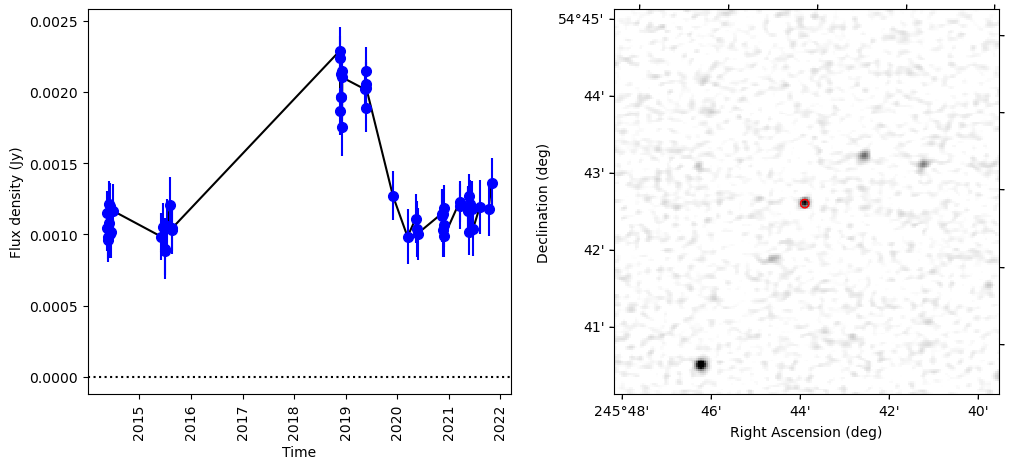

Runcat = 109826
245.5127502832372 54.848533721839324


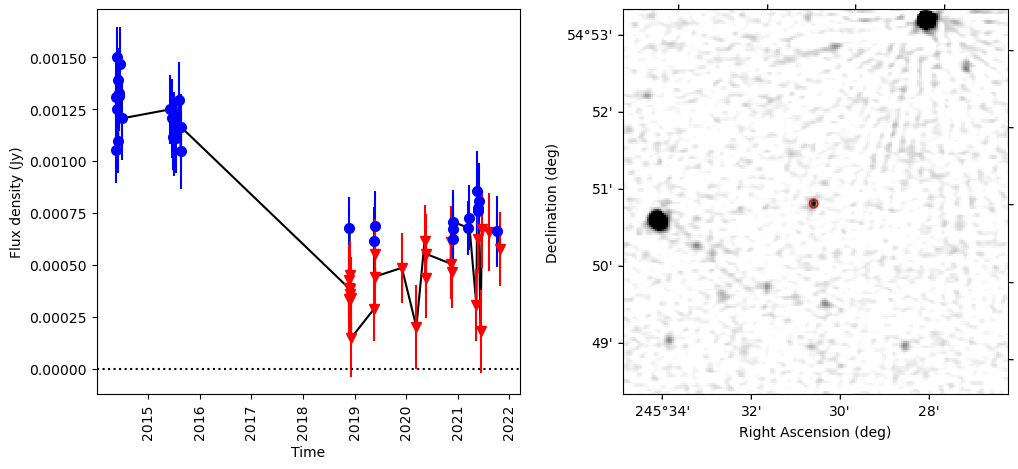

Runcat = 110291
244.96060551006306 53.09405210763144


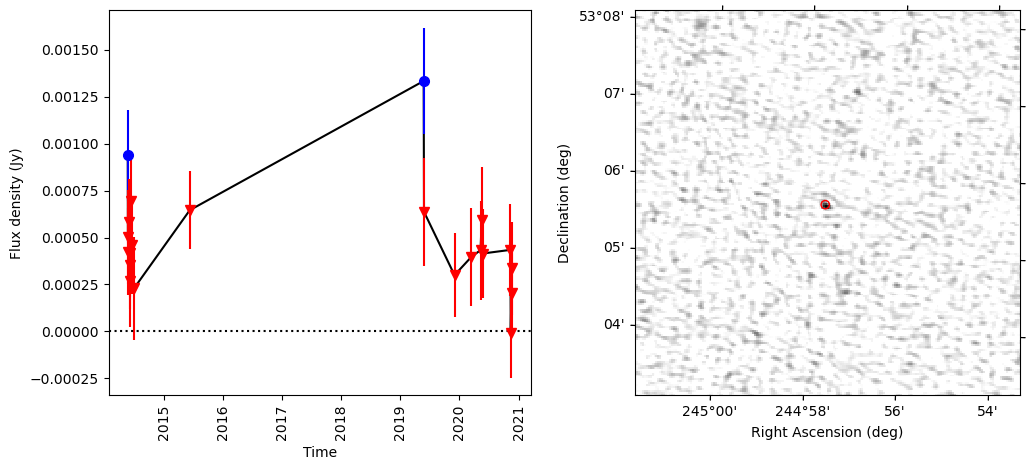

Runcat = 110317
244.93529806700562 53.00513700851835


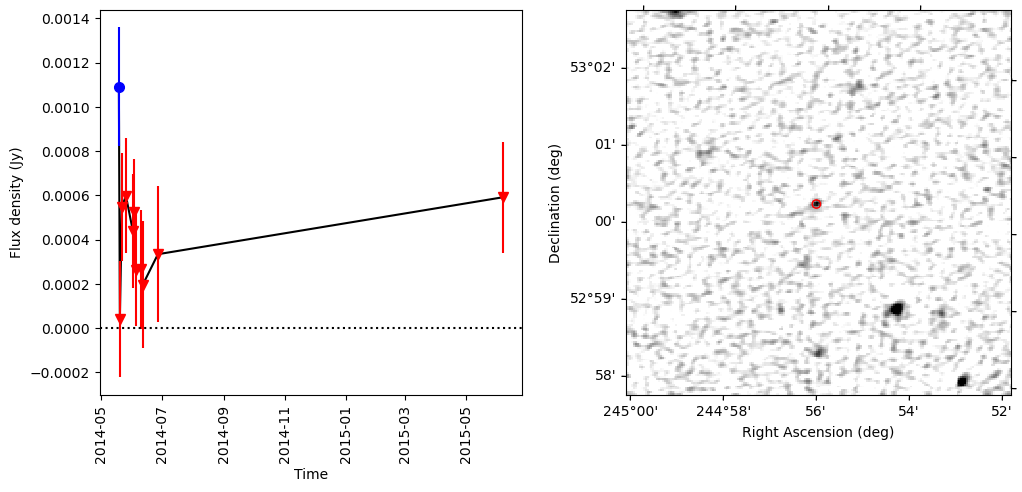

Runcat = 111365
244.2733074812661 55.26703293236653


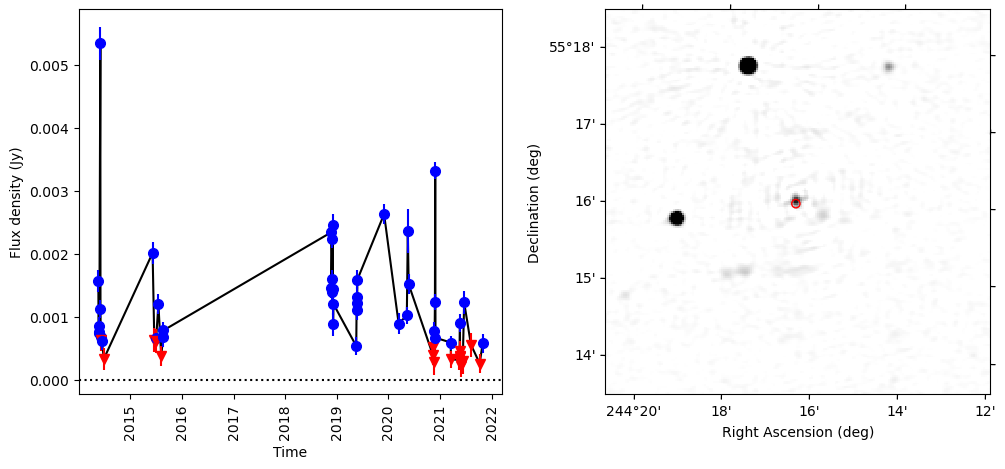

Runcat = 111912
243.91738075172864 55.509044780547654


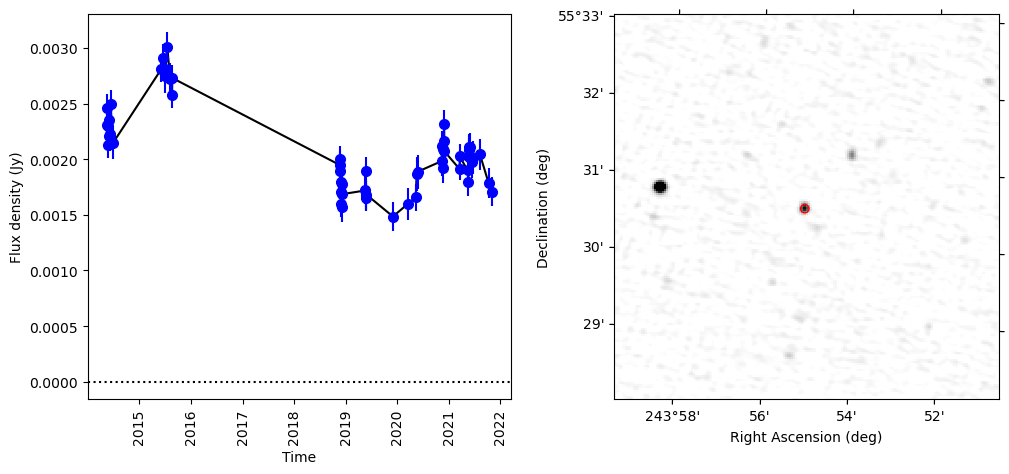

Runcat = 111928
243.86852708789036 54.222080935356445


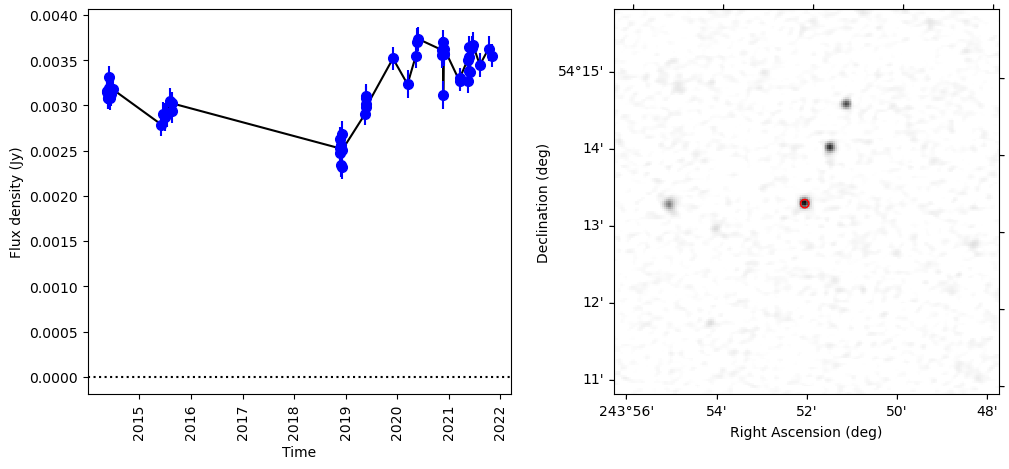

Runcat = 112029
243.82998048686085 54.81201523007807


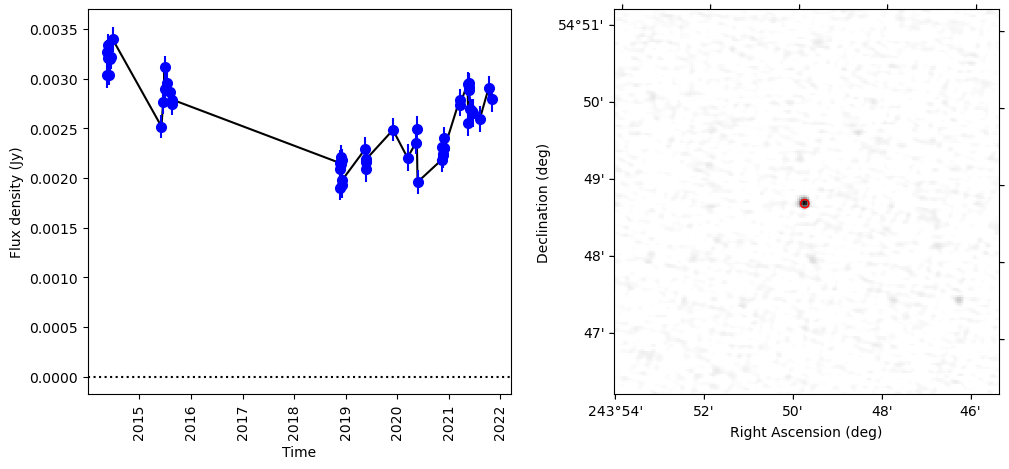

Runcat = 112130
243.7576476447634 54.86127327842773


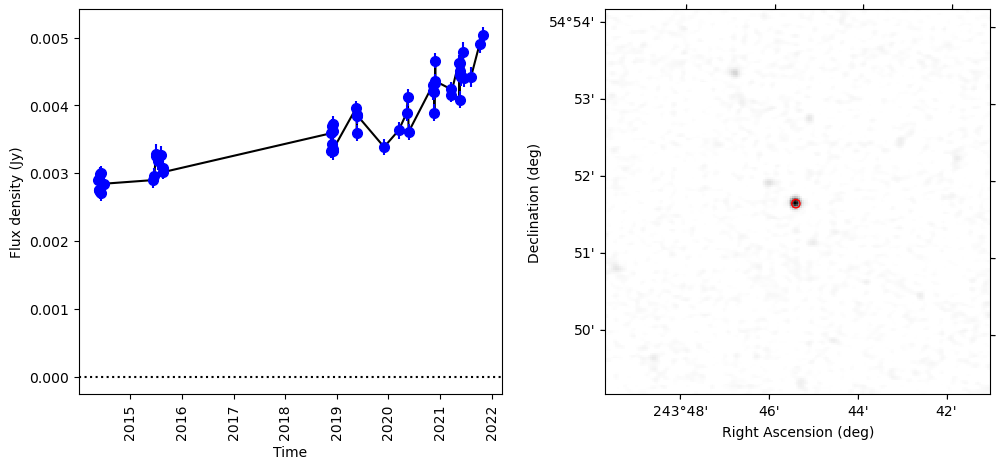

Runcat = 112714
243.37588493352686 55.80114092798666


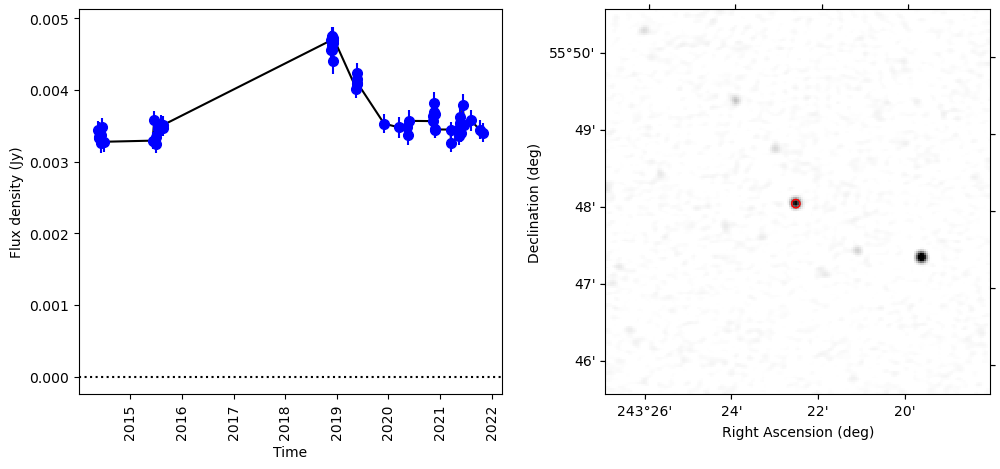

Runcat = 113341
242.96818768772064 54.02591820167909


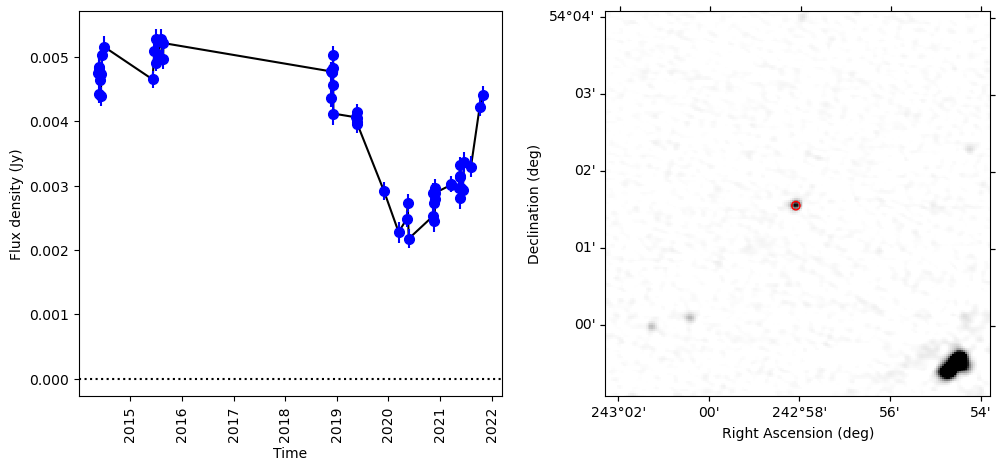

Runcat = 113590
242.81980395569568 53.33351970288101


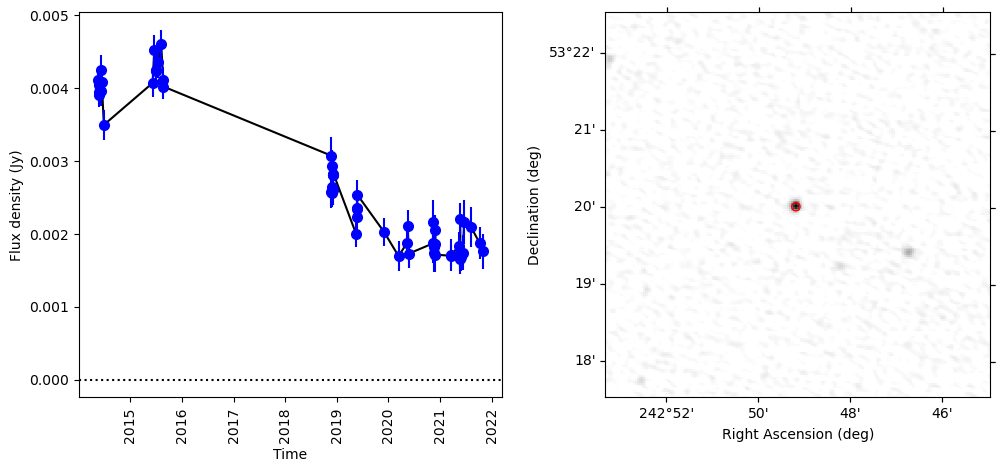

Runcat = 113769
242.7031020539191 56.772951983485775


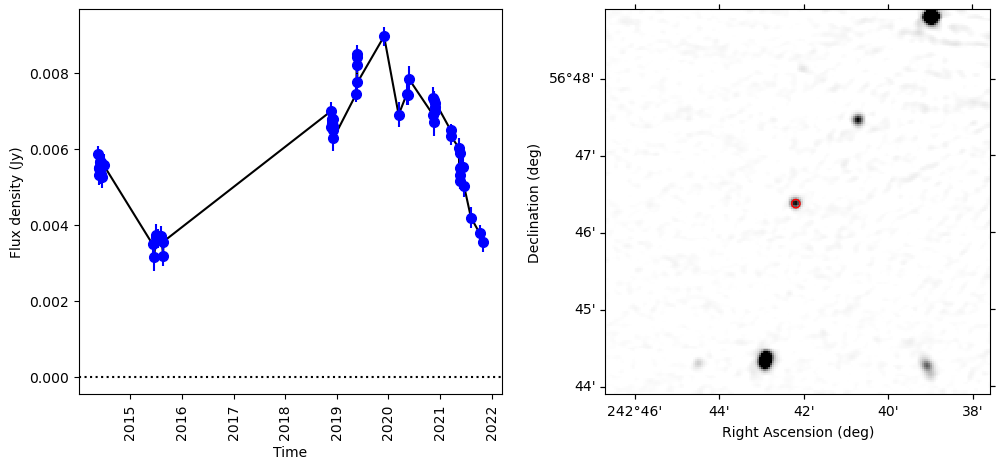

Runcat = 113790
242.69219144426614 54.39131651841738


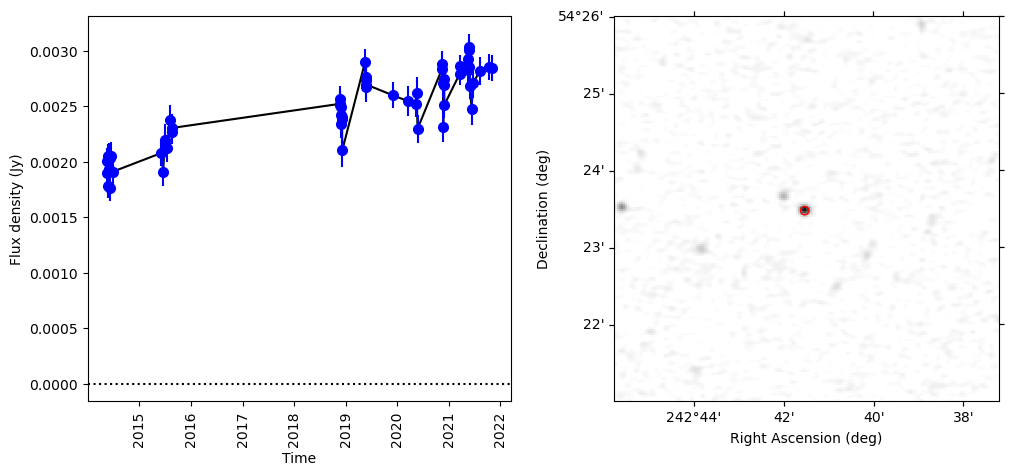

Runcat = 114628
242.11834890987507 56.902561099512475


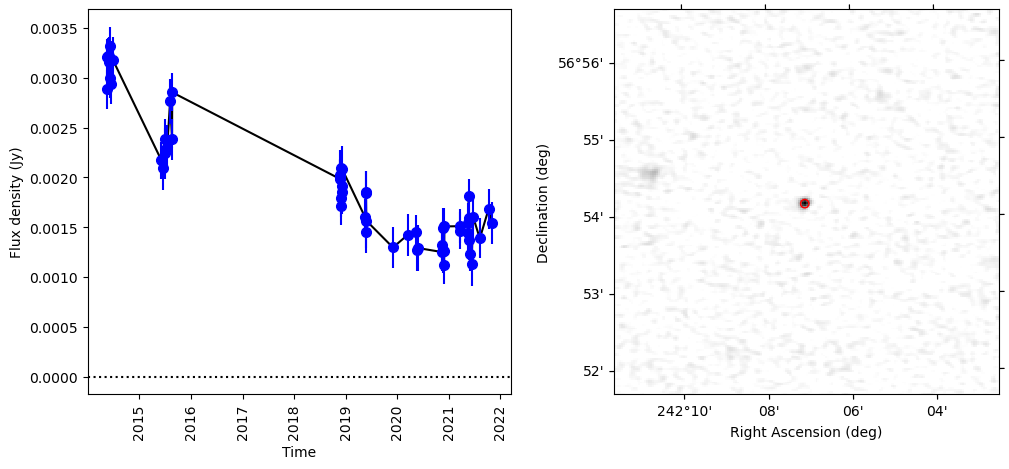

Runcat = 115040
241.88390817230953 54.37321851589269


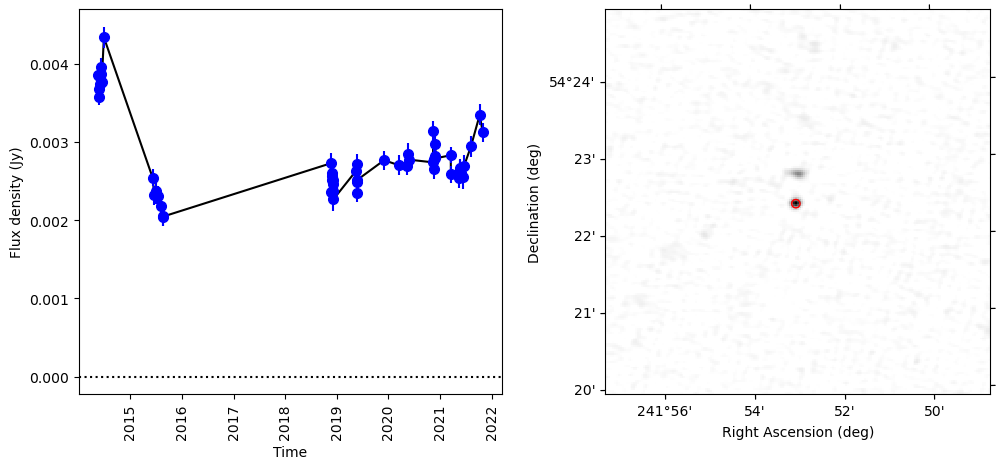

Runcat = 115595
241.50075255769266 53.260540546861904


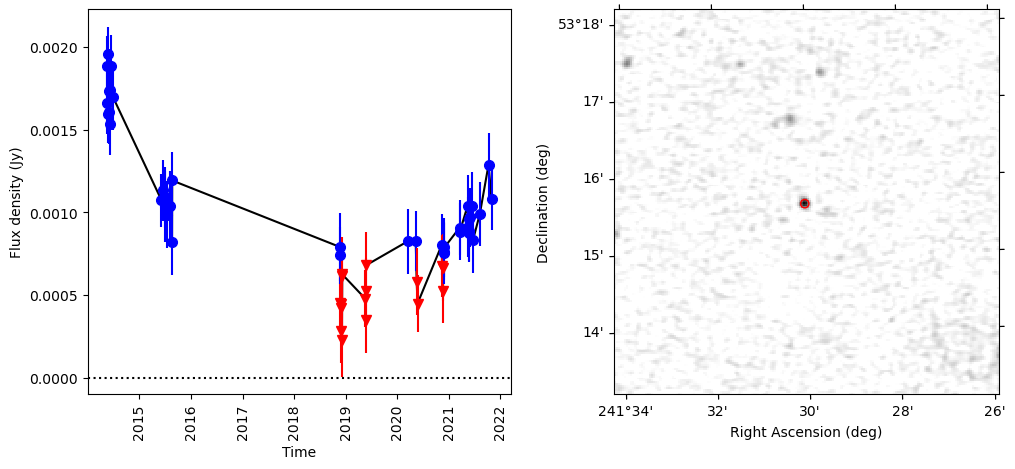

Runcat = 115967
241.0824650880328 57.265562493964865


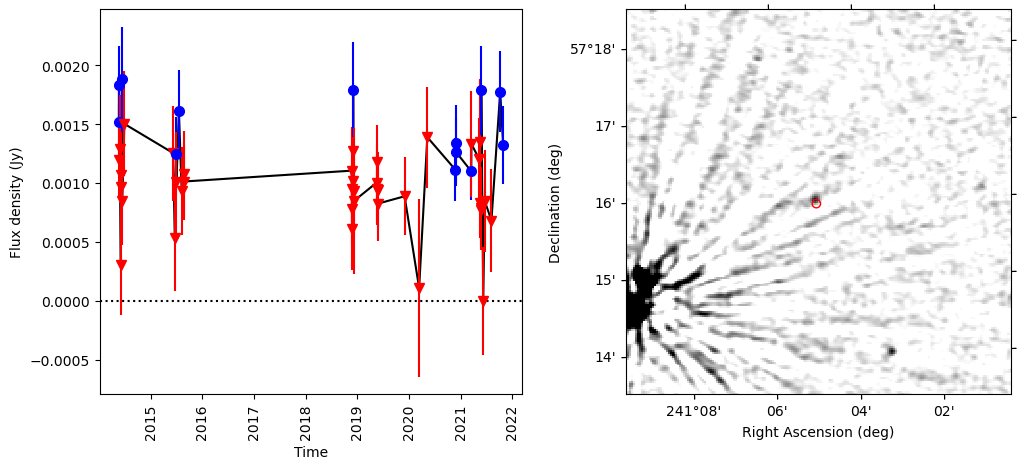

Runcat = 116129
241.03803125415115 55.30375329435363


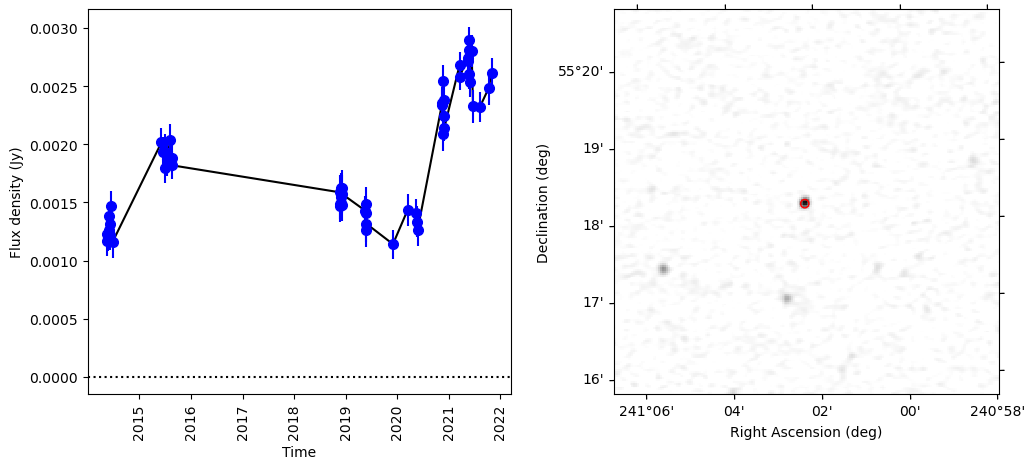

Runcat = 116696
240.46398588731327 56.370490754142004


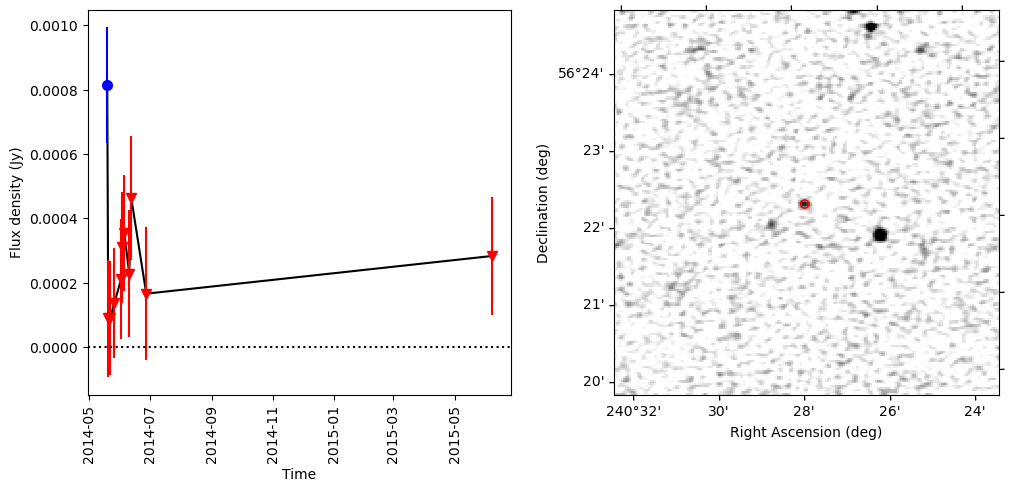

Runcat = 116772
240.56157258558065 53.23859269808058


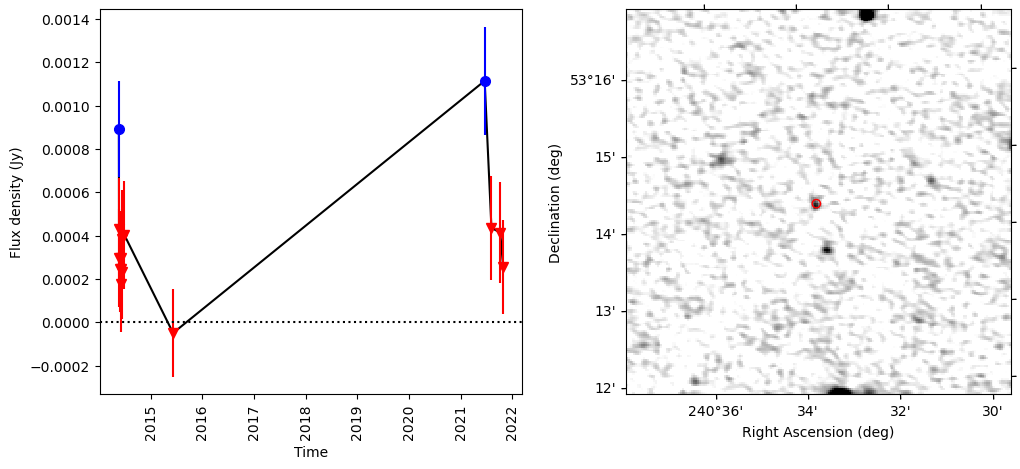

Runcat = 116820
240.32641447601648 56.40950555601131


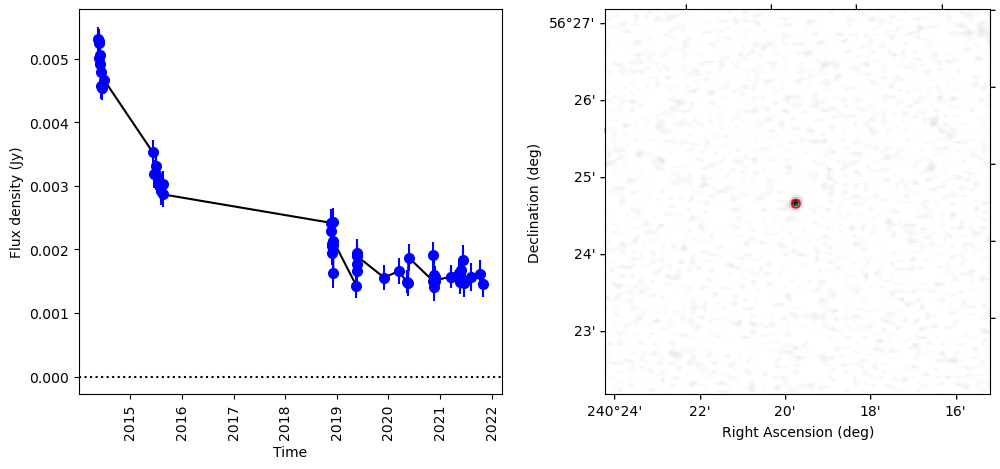

Runcat = 116880
240.2500506430773 56.82685586413277


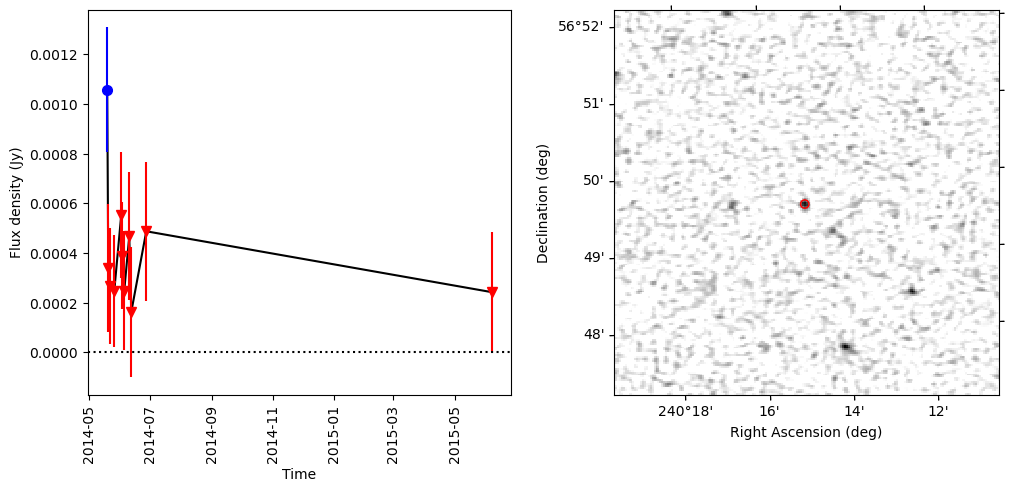

Runcat = 117019
240.16249686895443 55.59935744565747


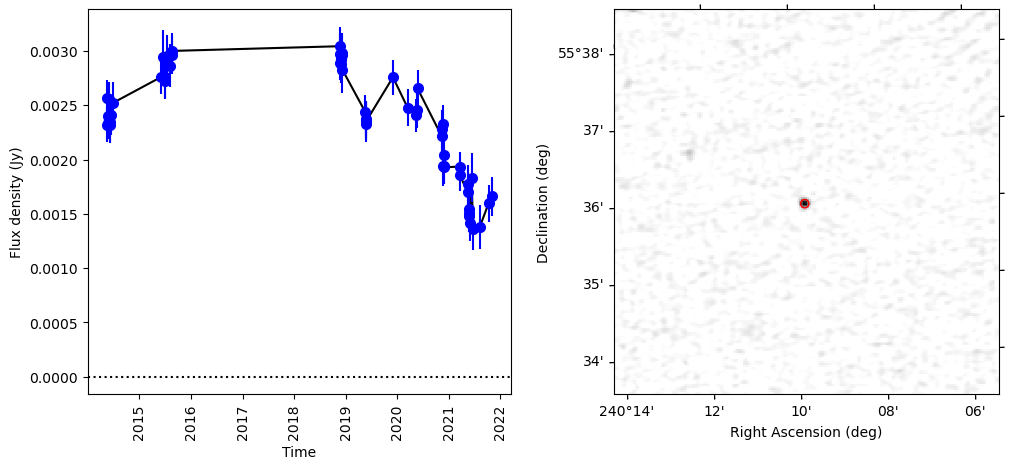

Runcat = 117256
239.90087184884925 54.70121109590302


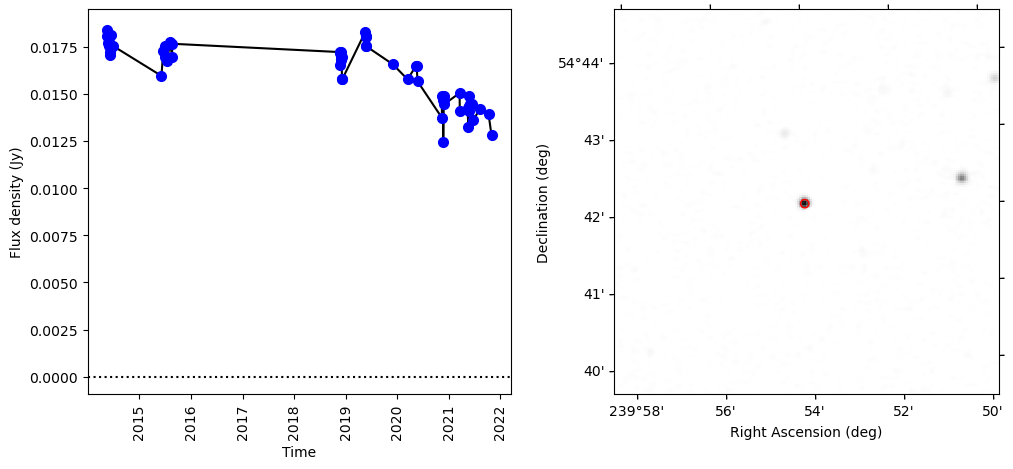

Runcat = 117264
239.9685907067639 53.5044779090278


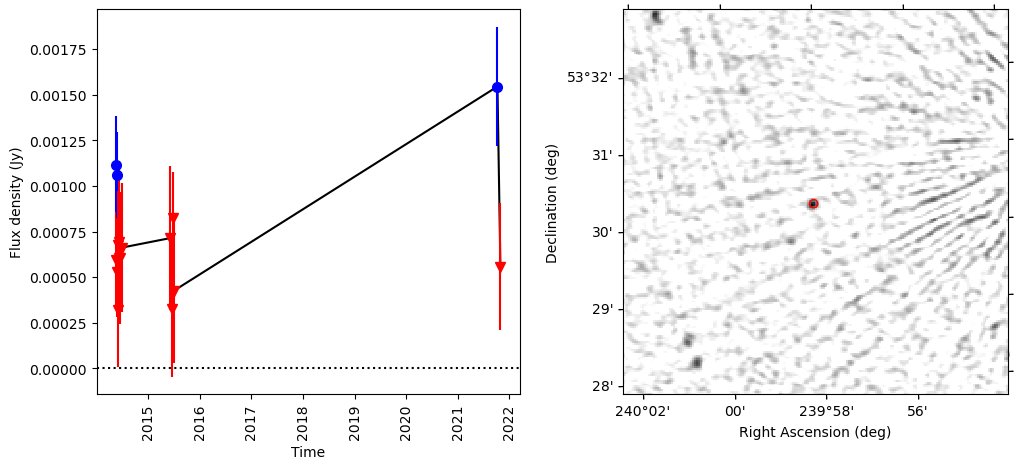

/tmp/ipykernel_582560/3190235413.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['maxImg']=maxImgs


In [147]:
maxImgs=[]
for index, row in variables.iterrows():
    sourceID = row.runcat
    flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type,flxVals[x].Extractedsource.reduced_chisq] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type','rchisq'])
    lightcurve = pd.merge(lightcurve, images, on="Image")

    print('Runcat = '+str(sourceID))
    print(row.ra,row.dec)
    #print(max(lightcurve.rchisq))

    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121)
    ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.type==0:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.type==1:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    maxFlux = np.max(lightcurve.Flux)
    maxFluxImg = lightcurve.loc[lightcurve.Flux==maxFlux]
    maxImgs.append(maxFluxImg.iloc[0].Image)

    extractedData, wcs = extract_data(maxFluxImg.iloc[0].Image,row.ra,row.dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
 
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()
    
variables['maxImg']=maxImgs

In [148]:
for index, row in variables.iterrows():
    sourceID = row.runcat
    print('Runcat = '+str(sourceID)+' position error = '+str(max(row.ra_err,row.dec_err)*3600)+' arcsec')
    result_table = Simbad.query_region(coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
    srcPos=coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5')
    if result_table:
        results = [[row['MAIN_ID'], row['RA'], row['DEC'], srcPos.separation(SkyCoord(str(row['RA'])+' '+str(row['DEC']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
        results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
        print(results)
    else:
        print('no matches')

Runcat = 109140 position error = 2.132336535018701 arcsec
no matches
Runcat = 109218 position error = 2.14161885341941 arcsec


no matches
Runcat = 109526 position error = 2.007813551861126 arcsec
                         ID            ra           dec  separation
0  SDSS J162343.07+551903.2  16 23 43.076  +55 19 03.22    0.438278
Runcat = 109639 position error = 2.0382853381892487 arcsec
no matches
Runcat = 109826 position error = 2.083944589936538 arcsec
no matches
Runcat = 110291 position error = 2.0674299511993492 arcsec


no matches
Runcat = 110317 position error = 2.0752610529553985 arcsec
no matches
Runcat = 111365 position error = 2.077915873883948 arcsec
            ID             ra            dec  separation
0  BD+55  1823  16 17 05.3518  +55 16 08.771     7.74776
Runcat = 111912 position error = 2.02554090596319 arcsec
no matches
Runcat = 111928 position error = 1.9541496758771464 arcsec
no matches
Runcat = 112029 position error = 1.9843783400005697 arcsec


                       ID            ra           dec  separation
0  FIRST J161519.1+544842  16 15 19.111  +54 48 42.46    1.068679
Runcat = 112130 position error = 1.98251061258241 arcsec
no matches
Runcat = 112714 position error = 2.0309102079697823 arcsec
no matches
Runcat = 113341 position error = 1.944100752080827 arcsec
                    ID            ra           dec  separation
0  NVSS J161152+540128  16 11 52.337  +54 01 32.79    0.559657
Runcat = 113590 position error = 1.934610599665045 arcsec


no matches
Runcat = 113769 position error = 2.086973954353548 arcsec
no matches
Runcat = 113790 position error = 1.964758718923689 arcsec
                ID           ra          dec  separation
0  [MJA2003] N1-21  16 10 46.03  +54 23 28.5     0.86854
Runcat = 114628 position error = 2.1347966921661348 arcsec
no matches
Runcat = 115040 position error = 1.962220854133081 arcsec


                          ID             ra            dec  separation
0  SWIRE J160732.07+542222.9  16 07 32.0320  +54 22 24.160    1.096714
Runcat = 115595 position error = 2.008054805472323 arcsec
             ID          ra        dec  separation
0  LEDA 2436071  16 06 00.1  +53 15 37      1.1806
Runcat = 115967 position error = 2.2774755835306713 arcsec
no matches
Runcat = 116129 position error = 2.0221435363688403 arcsec
                       ID             ra            dec  separation
0  FIRST J160409.0+551814  16 04 09.0381  +55 18 13.091    0.866733
Runcat = 116696 position error = 2.2171556279934306 arcsec
no matches
Runcat = 116772 position error = 2.0729006717729614 arcsec
no matches
Runcat = 116820 position error = 2.0952553801770706 arcsec
                    ID            ra           dec  separation
0  NVSS J160117+562434  16 01 18.276  +56 24 33.83    0.649624
Runcat = 116880 position error = 2.2694518325180186 arcsec
no matches
Runcat = 117019 position error = 2.037

                        ID             ra            dec  separation
0  2MASS J15593611+5442037  15 59 36.1411  +54 42 03.803    0.804175
Runcat = 117264 position error = 2.07041853611159 arcsec
no matches


Output a ds9 region file to plot positions on an image.

In [149]:
with open('ds'+str(dataset_id)+'_variable2_regions.reg', 'w') as f:
    f.write('# Region file format: DS9 version 4.1 \n')
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
    f.write('fk5 \n')
    for index, row in variables.iterrows():
        f.write('circle('+str(row.ra)+','+str(row.dec)
                    +',10") # text={'+str(row.runcat)+'} \n')
    f.close()


### Single epoch flares

The variability parameters used in the above analysis are good at identifying variability over multiple epochs, however they are bad at identifying sources that have a single epoch flare. [Valdata et al. (in prep)]() show that implementing a simple moving average search can successfully find these sources. n.b. this method is currently slow for large datasets and will require further optimisation.

In [150]:
y = session.query(Extractedsource,Assocxtrsource).select_from(join(Extractedsource,Assocxtrsource)).filter(Assocxtrsource.runcat_id.in_(plotdata.runcat)).all()
data = [[y[i].Extractedsource.id, y[i].Assocxtrsource.runcat_id, y[i].Extractedsource.image.taustart_ts, y[i].Extractedsource.f_int, y[i].Extractedsource.f_int_err] for i in range(len(y))]
data=pd.DataFrame(data=data, columns =['srcID','runcat','time','flux','fluxErr'])
data=data.sort_values(['runcat','time'])

In [158]:
window_size = 10  # the number of data points used for the moving average calculation
cutoff_val = 3 # the number of sigma used to determine the optimal cut on the 
minDatapoints = 10 # the minimum number of data points needed in the source light curve to be included in the analysis
sigma =3. # the number of sigma the deviation has to be above the flux uncertainties

In [159]:
finalData = pd.DataFrame(columns = ["srcID","runcat","time","flux","fluxErr","dpts","MAvg","deviation","candidate"])
runcatIDs = data.runcat.unique()

for runcat in runcatIDs:
    lc = data.loc[data['runcat'] == runcat]
    lc = lc.reset_index()
    lc["dpts"] = lc.index+1
    lc['MAvg'] = lc['flux'].rolling(window=window_size, min_periods=1).mean()
    std = lc.flux.std()
    lc['deviation'] = (lc['flux'] - lc['MAvg']) / std
    lc['candidate'] = np.where(np.abs(lc['flux'] - lc['MAvg']) > (sigma * lc['fluxErr']), 1, 0)
    lc = lc.fillna(0)
    lc = lc.drop('index',axis=1)
    finalData = finalData._append(lc, ignore_index=True)

# remove all rows with a zero deviation
finalData = finalData.loc[finalData['deviation'] != 0]

In [160]:
# Find transients that have deviation values that lie above threshold value
all_deviations = finalData.deviation
print(len(all_deviations))
devs = np.median(all_deviations)
params_med = devs, np.sqrt(np.mean([(i-devs)**2. for i in all_deviations]))
threshold = cutoff_val * params_med[1]

105493


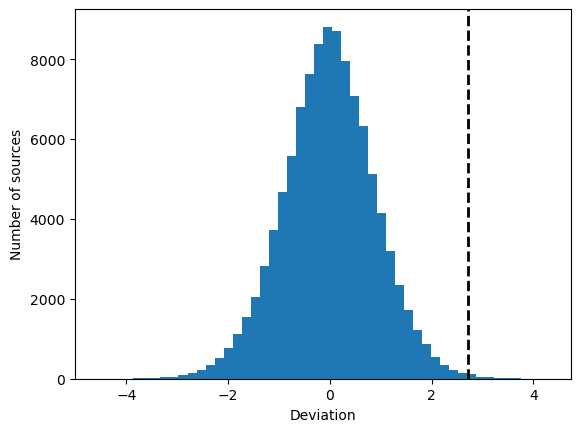

In [161]:
def plothist(x, threshold, filename):
# Create a histogram of the data t
    plt.hist(x,bins=50,histtype='stepfilled')
    plt.axvline(x=threshold, linewidth=2, color='k',linestyle='--')
    plt.xlabel('Deviation')
    plt.ylabel('Number of sources')
    plt.savefig(filename)
    plt.show()
    return
    
plothist(all_deviations, threshold, 'LOFAR_deviation_hist.png')

In [162]:
candidates = finalData.loc[(finalData['deviation'] > threshold) & (finalData['dpts'] >= minDatapoints) & (finalData['candidate'] == 1)]

if len(candidates) == 0:
    print('No candidate variable sources found.')
    srcs=[]
else:
    srcs=list(candidates.runcat)
    print(len(srcs))

5


Runcat = 111709
244.0461198441197 55.24766364628734


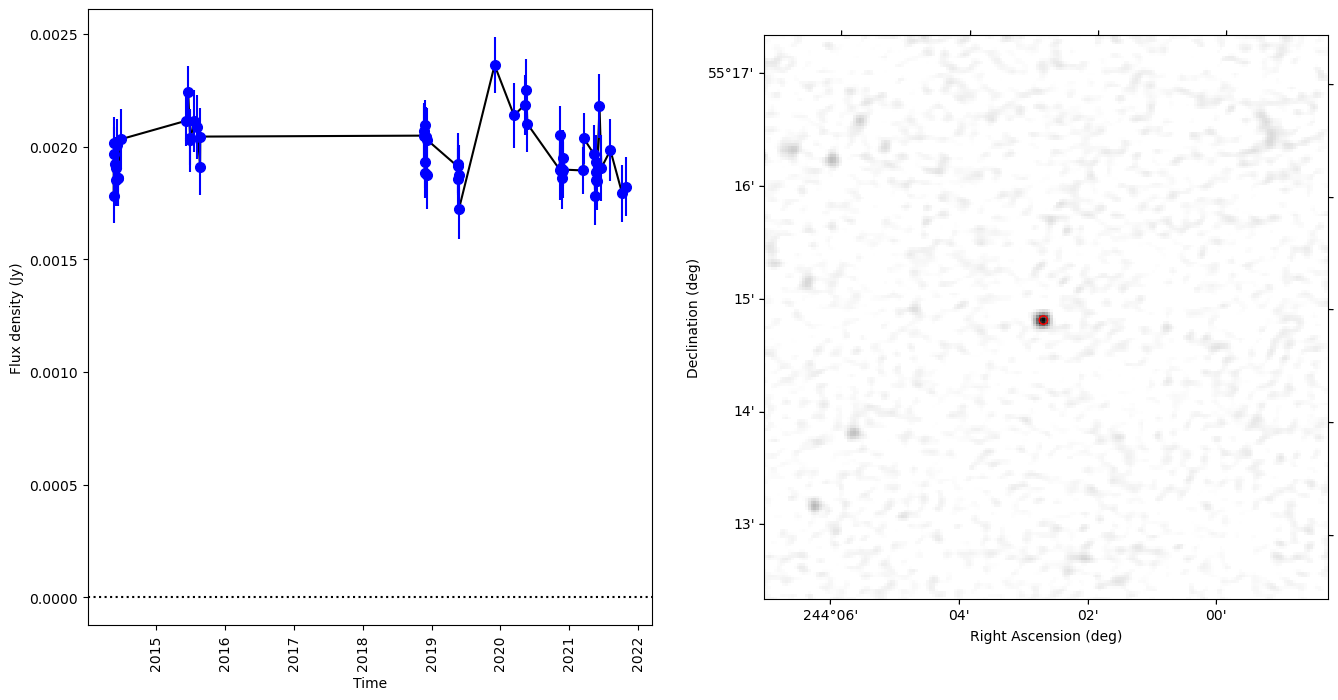

Runcat = 111709 position error = 2.0119818868889916 arcsec
                       ID             ra            dec  separation
0  FIRST J161611.0+551451  16 16 11.0181  +55 14 50.851    0.844309
Runcat = 112530
243.46332920318375 53.60704224982514


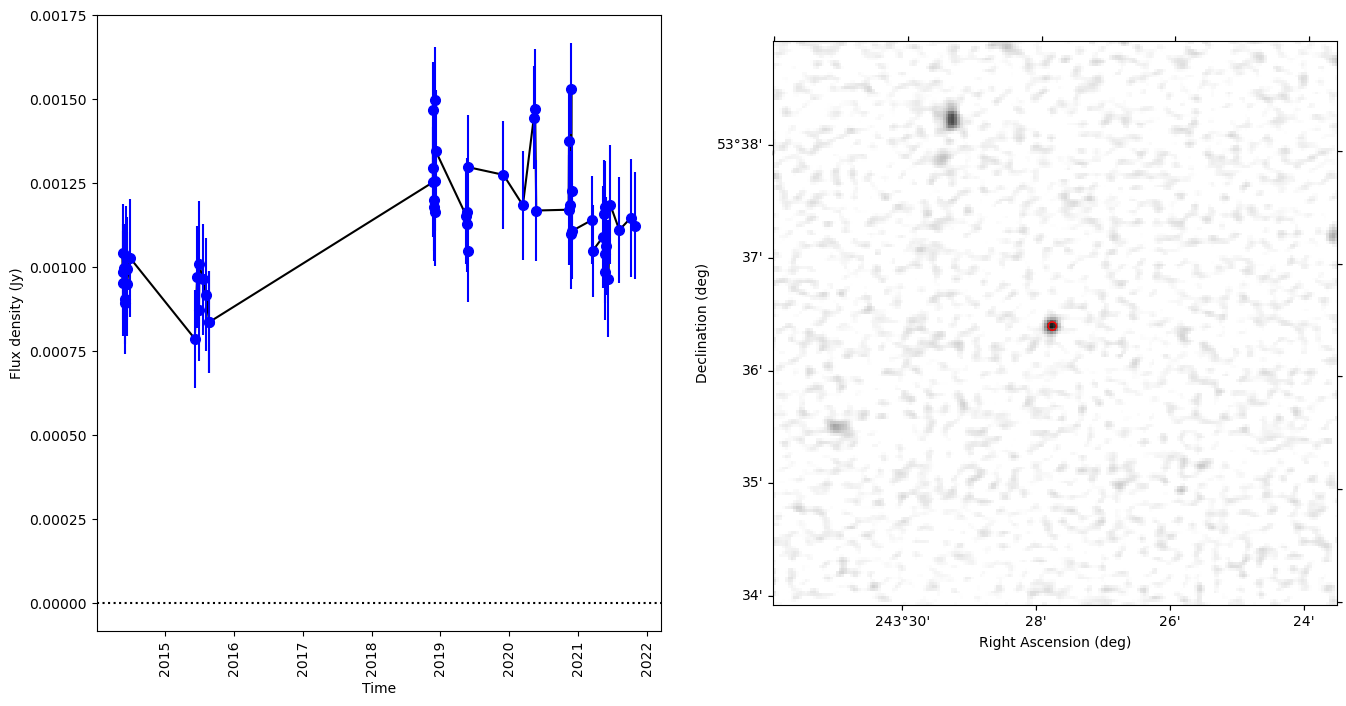

Runcat = 112530 position error = 1.9836466675888935 arcsec
no matches
Runcat = 112690
243.38518278376662 55.14317897383592


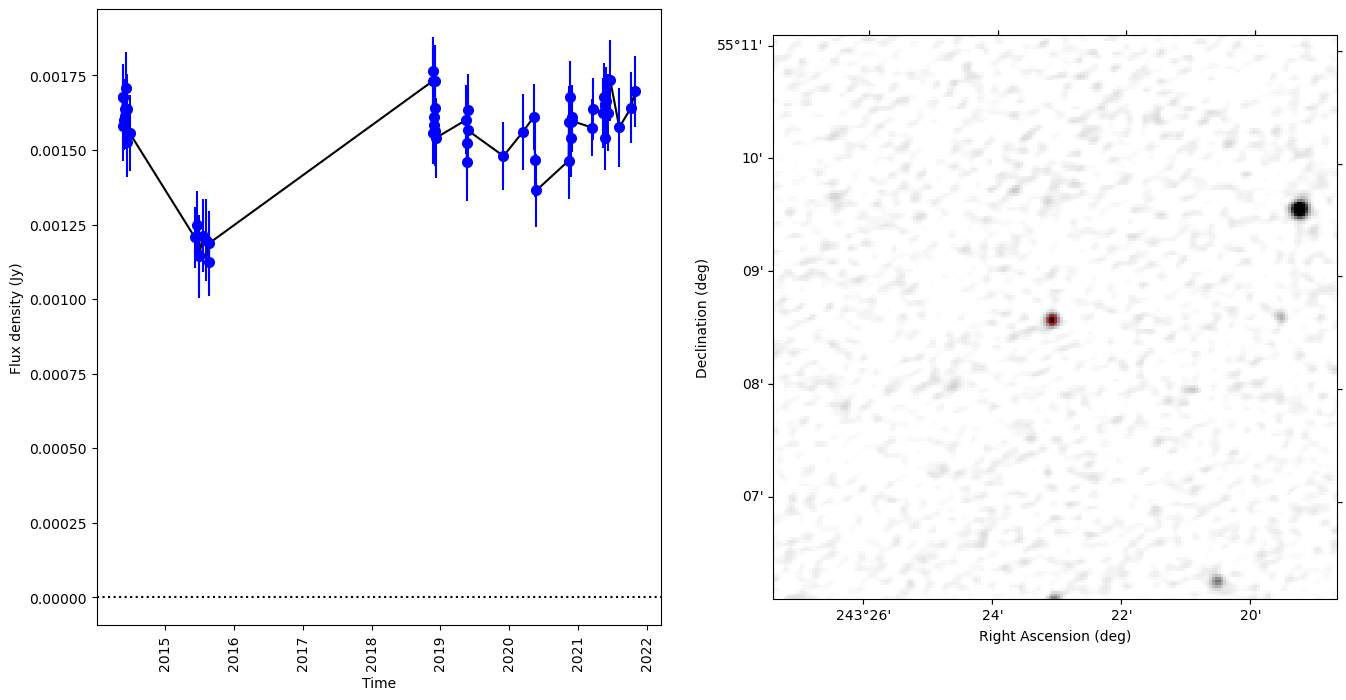

Runcat = 112690 position error = 2.0127877740238653 arcsec
                       ID            ra           dec  separation
0  FIRST J161332.3+550834  16 13 32.386  +55 08 34.98    0.670853
Runcat = 116772
240.56157258558065 53.23859269808058


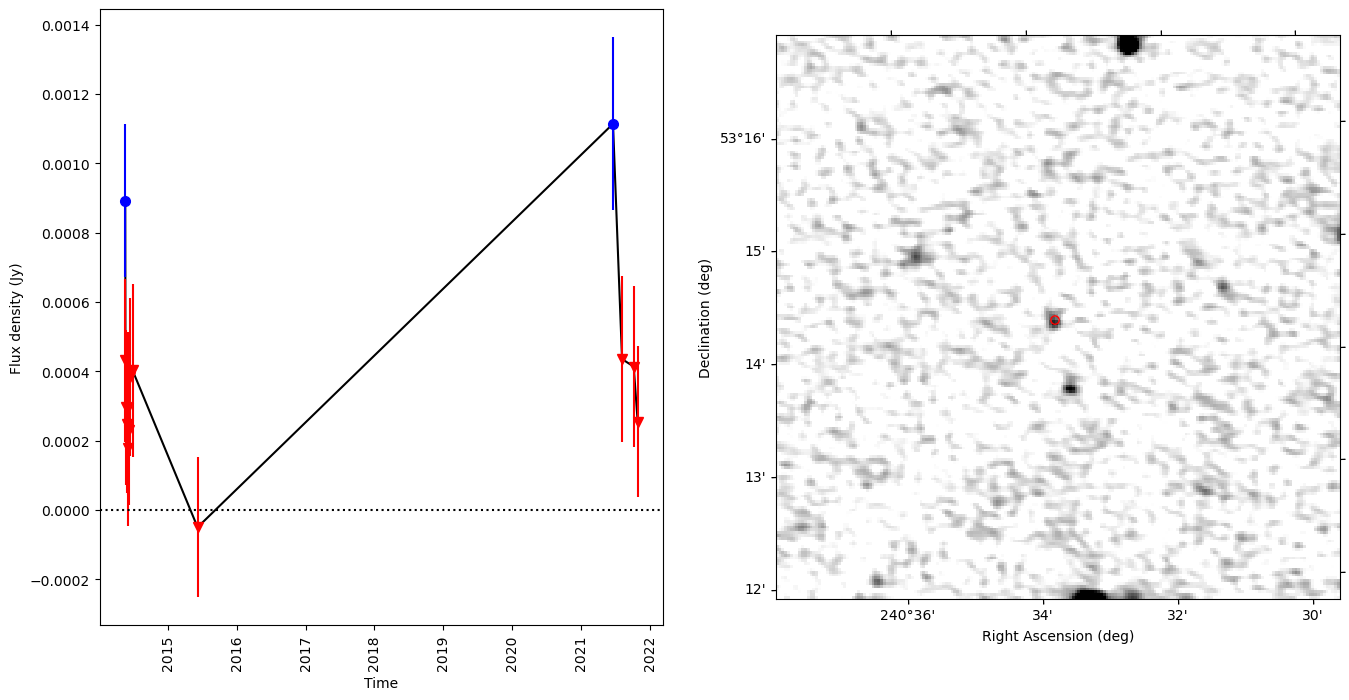

Runcat = 116772 position error = 2.0729006717729614 arcsec
no matches


In [163]:
for index, row in plotdata.iterrows():
    sourceID = row.runcat
    if sourceID in srcs:
        flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
        lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type'])
        lightcurve = pd.merge(lightcurve, images, on="Image")

        print('Runcat = '+str(sourceID))
        print(row.ra,row.dec)
        fig = plt.figure(figsize=(16, 8))
        ax1 = fig.add_subplot(121)
        ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
        for index2, row2 in lightcurve.iterrows():
            if row2.type==0:
                ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
            if row2.type==1:
                ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
        ax1.axhline(y=0.0, color='k', linestyle=':')
        ax1.tick_params(axis='x', labelrotation=90)
        ax1.set_ylabel('Flux density (Jy)')
        ax1.set_xlabel('Time')

        maxFlux = np.max(lightcurve.Flux)
        maxFluxImg = lightcurve.loc[lightcurve.Flux==maxFlux]

        extractedData, wcs = extract_data(maxFluxImg.iloc[0].Image,row.ra,row.dec,size)
        ax2 = fig.add_subplot(122, projection=wcs)
        fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
        ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
        ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
        ax2.coords[0].set_format_unit(u.deg)
        ax2.coords[1].set_format_unit(u.deg)
 
        ax2.set_xlabel('Right Ascension (deg)')
        ax2.set_ylabel('Declination (deg)')
        plt.show()

        # Find any associated sources in Simbad
        print('Runcat = '+str(sourceID)+' position error = '+str(max(row.ra_err,row.dec_err)*3600)+' arcsec')
        result_table = Simbad.query_region(coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
        srcPos=coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5')
        if result_table:
            results = [[row['MAIN_ID'], row['RA'], row['DEC'], srcPos.separation(SkyCoord(str(row['RA'])+' '+str(row['DEC']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
            results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
            print(results)
        else:
            print('no matches')

Write a ds9 regions file of the candidates

In [164]:
with open('ds'+str(dataset_id)+'_flares_regions.reg', 'w') as f:
    f.write('# Region file format: DS9 version 4.1 \n')
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
    f.write('fk5 \n')
    for index, row in variables.iterrows():
        f.write('circle('+str(row.ra)+','+str(row.dec)
                    +',10") # text={'+str(row.runcat)+'} \n')
    f.close()


### Transient searches

The previous methods focused on sources that were identified in the first image in a dataset and are looking for significant variability. Another key science case is transient sources, namely sources that were not detected in the first image and were found in subsequent images. The TraP has a specific table for newly identified sources, [newsource](https://tkp.readthedocs.io/en/release4.0/devref/database/schema.html#newsource). 

The following code is based upon the *filter_new_sources.py* example code in the [TraP_tools](https://github.com/transientskp/TraP_tools) repository.

In [ ]:
from tkp.db.model import Newsource
NewSrcs = session.query(Newsource, Runningcatalog).select_from(join(Newsource, Runningcatalog)).filter(Runningcatalog.dataset_id ==dataset_id).all()

In [ ]:
NewSrcData=[[NewSrcs[i].Runningcatalog.id,NewSrcs[i].Newsource.trigger_xtrsrc.ra,NewSrcs[i].Newsource.trigger_xtrsrc.decl,NewSrcs[i].Newsource.trigger_xtrsrc.id,
             NewSrcs[i].Newsource.trigger_xtrsrc.image.taustart_ts,NewSrcs[i].Newsource.trigger_xtrsrc.det_sigma,NewSrcs[i].Newsource.newsource_type,
             SkyCoord(ra=(NewSrcs[i].Runningcatalog.wm_ra*u.degree),dec=(NewSrcs[i].Runningcatalog.wm_decl*u.degree)),NewSrcs[i].Newsource.trigger_xtrsrc.image.url] for i in range(len(NewSrcs))]
NewSrcDataFrame = pd.DataFrame(data=NewSrcData, columns=['RuncatID','ra','dec','xtrsrc','TimeDetect','detSigma','type','SkyCoord','detectImage'])
NewSrcDataFrame = NewSrcDataFrame.sort_values(by=['detSigma'])
NewSrcDataFrame

**xtrsrc** is the id of the extracted source that was the first detection of this source

**TimeDetect** is the detection time of the new source

**detSigma** is the significance of the new source detection

**type** Refers to how certain we are that the newly discovered source is really “physically new”, i.e. transient. Since we do not store fine-grained noise-maps in the database, we must be fairly conservative in our labelling here. Type 0 sources may be a steady source located in a high-RMS region, newly detected due to noise fluctuations, or may be a real transient in a low-RMS region. Type 1 sources are bright enough that we can be fairly certain they are really new - they are significantly brighter than the rms_max in the previous image with best detection limits. (definition from the TraP documentation for the [newsource table](https://tkp.readthedocs.io/en/release4.0/devref/database/schema.html#newsource).)

In [ ]:
print("Number of new sources (before Filtering): "+str(len(NewSrcDataFrame)))

#### Filter 0: Remove any sources that fit poorly to the restoring beam
i.e. extended sources and sources that are not point like

In [ ]:
extendedSrcs=[]
for index, row in NewSrcDataFrame.iterrows():
    sourceID = row.xtrsrc
    extractedSrcs = session.query(Extractedsource).filter(Extractedsource.id == sourceID).all()
    fit_value = extractedSrcs[0].reduced_chisq 
    if fit_value>100:
        extendedSrcs.append(row.RuncatID)
print(extendedSrcs)
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(extendedSrcs)]

#### Filter 1: Remove any sources that are caused by source association errors and were detected in the first image

First obtain a list of all the sources detected in the first image and then conduct a simple source association between them. We define a source association radius as the typical maximum restoring beam size multiplied by the number of beam widths that we would consider two sources to be associated within. The beam widths can be the same as used in the TraP job_param.cfg file (see beamwidths_limit in example above).

**CAVEAT:** This only works when you are processing a single field. It will need adapting for multiple fields.

In [ ]:
# obtain all the sources in the first image from the dataset
images= session.query(Image).select_from(Image).filter(Image.dataset_id == dataset_id).all()
Imgs = [images[i].id for i in range(len(images))]
Img1 = min(Imgs)
ExtractedSrcs = session.query(Extractedsource, Assocxtrsource).select_from(join(Extractedsource, Assocxtrsource)).filter(Extractedsource.image_id == Img1).all()
Img1Srcs = [ExtractedSrcs[i].Assocxtrsource.runcat.id for i in range(len(ExtractedSrcs))]

# find the restoring beam major axis from the first image - n.b. we assume all images have roughly the same BMaj in this analysis
BMaj = images[0].rb_smaj

In [ ]:
# define the number of beam widths you want to use for association
beamwidths = 5.

# here we calculate the source association radius in degrees. 
# Instead of using the beam width, you could simply insert a value here
SrcAssocRadius = BMaj * beamwidths *u.degree
print('Source association radius = '+str(SrcAssocRadius))

In [ ]:
# get the positions of all the runcat sources found in the first image
runcats_tmp = session.query(Runningcatalog).filter(Runningcatalog.id.in_(Img1Srcs)).all()
positions = [[runcats_tmp[i].id,runcats_tmp[i].wm_ra,runcats_tmp[i].wm_decl,SkyCoord(ra=(runcats_tmp[i].wm_ra*u.degree),dec=(runcats_tmp[i].wm_decl*u.degree))] for i in range(len(runcats_tmp))]
positions = pd.DataFrame(positions, columns=['runcat','ra','dec','SkyCoord'])

In [ ]:
# Now conduct a simple source association
newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)
img1Pos = SkyCoord(ra=(positions.ra.values)*u.degree,dec=(positions.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(img1Pos)
NewSrcDataFrame['nearestSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestSrc > SrcAssocRadius]

In [ ]:
print("Number of new sources (after Filter 1): "+str(len(NewSrcDataFrame)))

#### Filter 2: Reject all sources that are too close to the source extraction radius

There is a known issue of false positive sources getting identified at the source extraction radius. We aim to address this in future versions of the source finder. For now, we reject any sources that are too close to the extraction radius by a given FilterRadius.

**CAVEAT:** this implementation assumes that all the images are of the same sky region. If you want to process multiple sky regions, you need to generalise this code.

In [ ]:
FilterRadius = 0.1 # in degrees, 0.017~1'

In [ ]:
from tkp.db.model import Skyregion

skyreg = session.query(Skyregion).select_from(Skyregion).filter(Skyregion.dataset_id == dataset_id).one() # open up the first sky region file
centre = SkyCoord(ra=(skyreg.centre_ra*u.degree),dec=(skyreg.centre_decl*u.degree)) # get the central co-ordinates of the sky region
xtrRadius = skyreg.xtr_radius # get the extraction radius used in TraP


In [ ]:
filteredRuncats=[]
for index, row in NewSrcDataFrame.iterrows():
    sep = row.SkyCoord.separation(centre)
    if sep.degree < xtrRadius - FilterRadius:
        filteredRuncats.append(row.RuncatID)

NewSrcDataFrame = NewSrcDataFrame[NewSrcDataFrame['RuncatID'].isin(filteredRuncats)]

In [ ]:
print("Number of new sources (after Filter 2): "+str(len(NewSrcDataFrame)))

#### Filter 3: Is the source in the NVSS Catalogue?

This is an example to show how to filter the sources against a catalogue. The goal of the transient search is to find new, undetected sources, therefore they should not be associated with a catalogue source.

In [ ]:
from astroquery.xmatch import XMatch
from astropy.table import Table

MaxSep = BMaj * beamwidths * 3600. # in arcsec

input_table = Table.from_pandas(NewSrcDataFrame)

table = XMatch.query(cat1=input_table,
                     cat2='vizier:VIII/65/nvss',
                     max_distance=MaxSep * u.arcsec, colRA1='ra',
                     colDec1='dec')

# The LoTSS DR1 sky catalogue is 'vizier:J/A+A/622/A1'

table = table.to_pandas()

In [ ]:
assoc_runcats = list(table.RuncatID)
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(assoc_runcats)]

In [ ]:
print("Number of new sources (after Filter 3): "+str(len(NewSrcDataFrame)))

#### Filter 4: Is the source in the deep image?

Some catalogues may not be sufficiently deep or at a sufficiently good observing frequency for all the associations with constant sources to be found. Therefore, it is often good to compare your newly detected sources to a deep image of the field made using the same instrument. Here, we use a deep image of the field but you could also simply use a catalogue.

We first run the PySE source finder on the image. PySE is the standalone version of the sourcefinder from TraP. I recommend using the same sourcefinder parameters as you specified in the TraP job_params.cfg file.

**CAVEAT:** Bright single epoch transient sources may still be detected in the deep image. One check for this is to see if the source is significantly brighter than the flux density measured in the deep image.

**CAVEAT:** This only works when you are processing a single field. It will need adapting for multiple fields.

In [ ]:
import os

DeepImg = '/scratch/antoniar/ELAIS_deep_images/L229064_image_full_ampphase_di_m.NS.int.restored_scaled.fits'

os.system('pyse.py --detection 8 --analysis 3 --force-beam --csv '+DeepImg)

In [ ]:
deepSrcs = pd.read_csv(DeepImg.split('.')[0]+'.csv', delimiter=", ")

newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)
deepSrcsPos = SkyCoord(ra=(deepSrcs.ra.values)*u.degree,dec=(deepSrcs.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(deepSrcsPos)
NewSrcDataFrame['nearestDeepSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestDeepSrc > SrcAssocRadius]

In [ ]:
print("Number of new sources (after Filter 4): "+str(len(NewSrcDataFrame)))

#### Filter 5: Removing side lobes

To see a full analysis of how to handle sidelobes, refer to [de Ruiter et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.2412D/abstract) and [de Ruiter et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023arXiv231107394D/abstract).

Here we conduct a simple cut using a fixed radius and the brightest sources in the field. This reduces the sky area surveyed so will need taking into account if you calculate transient surface density limits.

**CAVEAT:** This is needed for arrays like LOFAR where sidelobe artefacts occur somewhat frequently. Arrays with dishes, such as MeerKAT, do not typically need this. Look at a batch of your data and see what suits it best.

In [ ]:
FilterRadius = 4. # in arcmin (taken from table 2 in de Ruiter et al. (2023). This is probably reasonable and conservative for most LOFAR data.
BrightSrcFlx = 0.5 # Jy

# Reminder: the positions dataframe contains all the runcat sources in the first image and Img1Srcs is a list of all the runcat ids
# we need the average flux density from the runningcatalog_flux table
from tkp.db.model import RunningcatalogFlux

runcat_fluxes = session.query(RunningcatalogFlux).filter(RunningcatalogFlux.id.in_(Img1Srcs)).all()
runcat_fluxes = [[runcat_fluxes[i].id,runcat_fluxes[i].avg_f_int] for i in range(len(runcat_fluxes))]
runcat_fluxes = pd.DataFrame(data=runcat_fluxes, columns=['RuncatID','AvgFlx'])

# now identify the brightest sources
runcat_bright = runcat_fluxes.loc[runcat_fluxes.AvgFlx > BrightSrcFlx]
brightSrcs = runcat_bright['RuncatID'].tolist()

# Now conduct a simple source association between these sources and the transient candidates



newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(img1Pos)
NewSrcDataFrame['nearestBrtSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestBrtSrc > FilterRadius/60. ]


In [ ]:
print("Number of new sources (after Filter 5): "+str(len(NewSrcDataFrame)))

#### Other possible filters

These are 5 key filters that you can use on your transient source candidates. There are other options which can be applied to your data, such as:
- using 2 or more observing frequency bands and requiring that the source is present in all of them (good for removing e.g. noise fluctuations or narrow-band RFI sources)
- worth investigating - extended sources are not going to be transient sources, so you could possibly use the source finder fit quality (see e.g. the parameters chisq, reduced_chisq from the extracted source table).

In [ ]:
NewSrcDataFrame

#### Bonus filter: remove planes and satellites

Sometimes planes and satellites can pass through your field of view giving a moving point source. This leads to multiple false positive new source detections that are sequentially following each other. See this image for example.

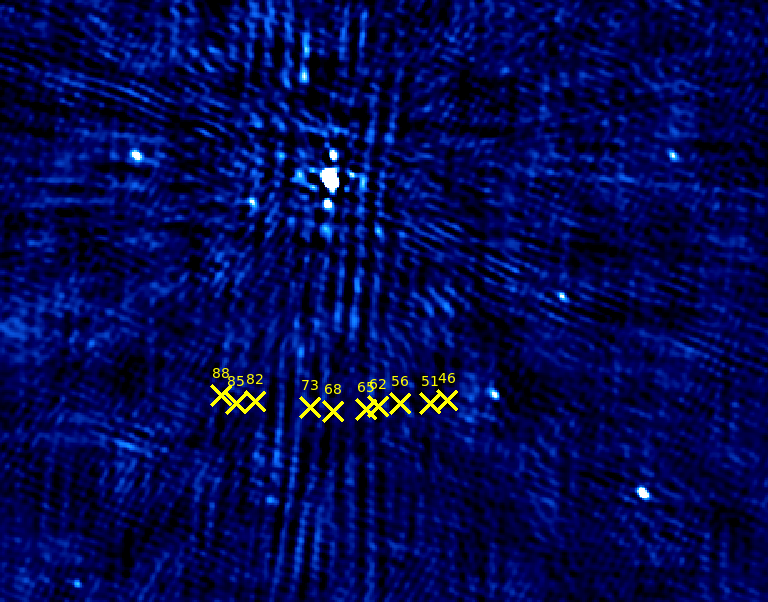

It is possible to filter these out of your false positives using a method developed for the AARTFAAC whole sky imager and outlined in the filtering stategies in [Kuiack et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.2966K/abstract). 
> "We found that excluding new source detections that occur within a space–time distance of 2.5° angular separation and 500 s was adequate to reject moving sources; these parameters were tuned using a sample data set which contained a number of transiting unidentified flying objects."

Sadly, with the advent of satellite constellations that are emitting or reflecting radiation (for LOFAR and Starlink see e.g. [Di Vruno et al.](https://ui.adsabs.harvard.edu/abs/2023A%26A...676A..75D/abstract)) and filters like this will likely become more important.

The following code is based upon the filtering strategy developed by Kuiack and his code is available here on [GitHub](https://github.com/mkuiack/scratchpad/blob/2664e6812f16003e4947839d7de8a9d474e8cbc4/scripts/StreamingHarvest.py#L532-L538)

In [ ]:
# Loop through all the remaining candidates and remove sources associated in space (<2.5 deg) and time (<500 sec)
rejected_runcats=[]

for index, row in NewSrcDataFrame.iterrows():
    c1 = row.SkyCoord
    for index2, row2 in NewSrcDataFrame.iterrows():
        if index2 > index:
            c2 = row2.SkyCoord
            if (c1.separation(c2).deg < 2.5) and ((row2.TimeDetect-row.TimeDetect).total_seconds() < 600):
                rejected_runcats.append(row.RuncatID)
                rejected_runcats.append(row2.RuncatID)

rejected_runcats = np.unique(rejected_runcats)
rejected_runcats



In [ ]:
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(rejected_runcats)]
NewSrcDataFrame = NewSrcDataFrame.sort_values(by='detSigma', ascending=False)
NewSrcDataFrame

#### Visual Inspection

The goal is to filter as many noise artefacts as possible before reaching this stage. But, visual inspection is often required before confirming a source is transient. Here we plot the light curve and the detection image, in the same way as we did for the variable source candidates.

In [ ]:
images2 = session.query(Image).filter(Image.dataset_id == dataset_id).all()
images2 = pd.DataFrame(data=[[images[x].url,images[x].taustart_ts,np.around(images[x].band.freq_central/1e9, decimals=3)] for x in range(len(images))], columns=['Image','Time','Freq'])

for index, row in NewSrcDataFrame.iterrows():
    sourceID = row.RuncatID
    flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type'])
    lightcurve = pd.merge(lightcurve, images2, on="Image")

    print('Runcat = '+str(sourceID))
    print('RA: '+str(row.ra)+' Dec: '+str(row.dec))
    print('Image = '+row.detectImage)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.type==0:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.type==1:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    maxFlux=0.0005
    
    extractedData, wcs = extract_data(row.detectImage,row.ra,row.dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
 
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()
